# Authors

### Suphachart Leewiwatwong (sl609), Aoxue Miao (am729), Jiaxu Meng (jm611)

In [6]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import numpy as np
import re

from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

import os
import numpy
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc

from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot') 

# Overview and Background

We want to improve hospital operation by predicting the influence of diabetes on the risk of ICU mortality.

MIMIC-III will be installed in a local Postgres database.  Data will be extracted and processed to DCSI, Elixhauser, and CCS index by aggregating in tabular formats in terms of assigning scores based on ICD-9-CM diagnosis code.

The objective of this project is to predict and examine the influence of diabetes on outcome in ICU patients using predictive modeling approches including random forest, logistic regression, and their optimization.

We will also estimate which coefficients have the largest impact on the models.

We follow the paper  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961793/ as a guildline and extent the scope by including patients that don't have HbA1c data also we include patients with additional ICD9-code : 240.x-249.x, 357.2, 362.0, 366.41 and 648.4 which are also diabetic related code. The additional ICD9-codes are acquired from https://www.ncbi.nlm.nih.gov/pubmed/28416120.

In the project, our aims are 

1) find out how standard comordity scores perform on ICU diabetic patients and whether we can improve the model by using the combined method or by providing additional information(HbA1c, glucise and serum creatinine)

2) find out how the same model performs on different dataset 1) patients with HbA1c data and 2) patients with out the data.

3) find out which is the best way to create a model that can handle both cases of patients. Two approaches are tested in this project. 1) Building separate model on each dataset 2) changing HbA1c to catergorical data and add NaN as another category.

4) In Logistic Regression model, we want to find out which factor contributes to the result most.

# Data

In [7]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema = 'mimiciii'

In [8]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


We follow the paper

Predicting Mortality in Diabetic ICU Patients Using Machine Learning and Severity Indices: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961793/

We extract the data from the following tables: DIAGNOSES_ICD, LABEVENTS, PATIENTS, ADMISSIONS, ICUSTAYS. 

The DIAGNOSES_ICD is to extract icd9 for diabetic patients as well as to construct DCSI and CCS code. The diabetes-specific or diabetic-complication-included icd-9 code categories are based on the paper Diabetes Complications Severity Index (DCSI)-Update and ICD-10 translation: https://www.sciencedirect.com/science/article/pii/S105687271631042X
For Elixhauser code, we use the sql code from mimic-code to construct the Elixhauser table. 

We use PATIENTS to extract the date of birth to calculate their age at admission time.

We don't extract information from ICUSTAYS but we use it to make sure that the patients are in ICU units.

We extract HbA1c (50852,50854), Glucose (50931) and Serum creatinine (50912) from LABEVENTS using itemcode associated with the items. This is different from the paper in that they use loinc codes. We do this to reduce the processing time from combining labevents and labitems tables. 

In [9]:
# Get feature according to the paper

query = \
"""
with icd as
(
  select hadm_id, subject_id
    , cast(icd9_code as char(5)) as icd9_code
  from diagnoses_icd
)
, db_patience as
(select icd.subject_id
from icd
where icd9_code between '2500 ' and '2599 '
or icd9_code between '2400 ' and '2499 '
or icd9_code = '3572 '
or icd9_code = '3620 '
or icd9_code = '36641'
or icd9_code = '6484 '
group by 1
)
,lab_aggs as
(
select le.hadm_id
, min(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_min
, max(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_max
, avg(case when itemid in (50852,50854) then le.valuenum else null end) as HbA1c_mean
, min(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_min
, max(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_max
, avg(case when itemid in (50931) then le.valuenum else null end) as lab_glucose_mean
, min(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_min
, max(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_max
, avg(case when itemid in (50912) then le.valuenum else null end) as serum_creatinine_mean
from labevents le 
where itemid in
(50852,50854,50931,50912
)
group by 1

)





select ad.hadm_id,dbp.subject_id, ad.deathtime
, extract(epoch from (ad.admittime - p.dob))/60.0/60.0/24.0/365.242 as age
, p.gender as gender
, ad.marital_status as marital_status
, ad.admission_type
, ad.ethnicity
, ad.insurance as insurance
,HbA1c_min
,HbA1c_max
,HbA1c_mean
,lab_glucose_min
,lab_glucose_max
,lab_glucose_mean
,la.serum_creatinine_min
,la.serum_creatinine_max
,la.serum_creatinine_mean


from db_patience dbp
inner join patients p
on dbp.subject_id = p.subject_id
inner join admissions ad
on dbp.subject_id = ad.subject_id
inner join lab_aggs la
on ad.hadm_id = la.hadm_id
inner join icustays ie
on la.hadm_id = ie.hadm_id
and lab_glucose_mean is not null

group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
order by 1,2


;
"""

data = pd.read_sql_query(query,con)
print(data.shape)
data.head()

(20889, 18)


,hadm_id,subject_id,deathtime,age,gender,marital_status,admission_type,ethnicity,insurance,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean
0,100001,58526,NaT,35.476452,F,DIVORCED,EMERGENCY,WHITE,Private,NaN,NaN,NaN,65.0,305.0,165.428571,1.9,2.7,2.214286
1,100003,54610,NaT,59.912739,M,SINGLE,EMERGENCY,WHITE,Private,NaN,NaN,NaN,56.0,135.0,96.833333,0.9,1.3,1.083333
2,100009,533,NaT,60.797126,M,MARRIED,EMERGENCY,WHITE,Private,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333
3,100016,68591,NaT,55.512635,M,SINGLE,EMERGENCY,WHITE,Medicare,NaN,NaN,NaN,63.0,110.0,81.750000,1.0,1.2,1.112500
4,100018,58128,NaT,55.542455,M,MARRIED,ELECTIVE,WHITE,Private,NaN,NaN,NaN,54.0,224.0,134.133333,0.9,1.2,1.066667


## Assign Death label using deathtime

In [10]:
# Assign Death label from the availability of deathtime
data['Death'] = (~ np.isnat(data['deathtime'])).astype(int)
data.head()

,hadm_id,subject_id,deathtime,age,gender,marital_status,admission_type,ethnicity,insurance,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100001,58526,NaT,35.476452,F,DIVORCED,EMERGENCY,WHITE,Private,NaN,NaN,NaN,65.0,305.0,165.428571,1.9,2.7,2.214286,0
1,100003,54610,NaT,59.912739,M,SINGLE,EMERGENCY,WHITE,Private,NaN,NaN,NaN,56.0,135.0,96.833333,0.9,1.3,1.083333,0
2,100009,533,NaT,60.797126,M,MARRIED,EMERGENCY,WHITE,Private,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
3,100016,68591,NaT,55.512635,M,SINGLE,EMERGENCY,WHITE,Medicare,NaN,NaN,NaN,63.0,110.0,81.750000,1.0,1.2,1.112500,0
4,100018,58128,NaT,55.542455,M,MARRIED,ELECTIVE,WHITE,Private,NaN,NaN,NaN,54.0,224.0,134.133333,0.9,1.2,1.066667,0


In [11]:
# number of alive and death subject
data['Death'].value_counts()

0    18653
1     2236
Name: Death, dtype: int64

# Diabetes complications severity index (DCSI) 

In [12]:
# Gain data from diagnoses_icd to create DCSI score

In [13]:
query = \
"""
SELECT di.hadm_id,di.subject_id, di.ICD9_CODE
FROM diagnoses_icd di;
"""

diag = pd.read_sql_query(query,con)

In [14]:
diag.head()

,hadm_id,subject_id,icd9_code
0,172335,109,40301
1,172335,109,486
2,172335,109,58281
3,172335,109,5855
4,172335,109,4254


In [15]:
diag.shape

(651047, 3)

In [16]:
#Using eliminate hadm_id in diagnosis dataset that is not in our diabetic data. 
diag = diag[diag['hadm_id'].isin(data['hadm_id'])];

In [17]:
diag.head()

,hadm_id,subject_id,icd9_code
0,172335,109,40301
1,172335,109,486
2,172335,109,58281
3,172335,109,5855
4,172335,109,4254


In [18]:
diag = diag[diag['icd9_code'].notnull()]

In [19]:
diag.shape

(293525, 3)

Create DCSI severity score according to the paper Diabetes complications severity index and risk of mortality, hospitalization, and healthcare utilization. https://www.ncbi.nlm.nih.gov/pubmed/18197741

In [20]:
def severity_score(df):
    
    data = np.asarray(df['icd9_code']);
    scores = np.zeros([7]);
    try:
        for item in data:

            if re.match(r'^2505[0-9]$',item) or  re.match(r'^36201$',item) or  re.match(r'^3621$',item) or  re.match(r'^36283$',item) or  re.match(r'^336253$',item) or  re.match(r'^36281$',item) or  re.match(r'^36282$',item) :
                scores[0]=max(scores[0],1);
            elif re.match(r'^36202$',item) or  re.match(r'^361[0-9][0-9]$',item) or  re.match(r'^369[0-9][0-9]$',item) or  re.match(r'^37923$',item):
                scores[0]=max(scores[0],2);
            elif re.match(r'^2504$',item) or  re.match(r'^580$',item) or  re.match(r'^581$',item) or  re.match(r'^58181$',item) or  re.match(r'^582$',item) or  re.match(r'^583$',item) :
                scores[1]=max(scores[1],1);
            elif re.match(r'^585$',item) or  re.match(r'^586$',item) or  re.match(r'^5939$',item):
                scores[1]=max(scores[1],2);
            else:
                pattern3 = [r'^3569$',r'^2506$',r'^3581$',r'^9510$',r'^9511$',r'^9513$',r'^35[4-5][0-9]$',r'^7135$',r'^3572$',r'^59654$',r'^337[0-1]$',r'^5645$',r'^5363$',r'^4580$'];
                for p in pattern3:
                    if(re.match(p,item)):
                        scores[2]=max(scores[2],1);
            if re.match(r'^435$',item):
                scores[3]=max(scores[3],1);
            elif  re.match(r'^43[1,3,4,6]$',item):
                scores[3]=max(scores[3],2);
            elif re.match(r'^440[0-9][0-9]$',item) or  re.match(r'^41[1,3,4]$',item) or  re.match(r'^4292$',item):
                scores[4]=max(scores[4],1);
            elif re.match(r'^410$',item) or re.match(r'^427[1,3]$',item) or re.match(r'^427[4,5]$',item)or re.match(r'^412$',item)or re.match(r'^428$',item)or re.match(r'^4402[3,4]$',item)or re.match(r'^441$',item):
                scores[4]=max(scores[4],2);
            elif  re.match(r'^2507$',item) or re.match(r'^4423$',item) or re.match(r'^44381$',item) or re.match(r'^4439$',item) or re.match(r'^8921$',item):
                scores[5]=max(scores[5],1);
            elif  re.match(r'^44422$',item) or re.match(r'^7854$',item) or re.match(r'^040$',item) or re.match(r'^7071$',item):
                scores[5]=max(scores[5],2);
            elif  re.match(r'^250[1,2,3]$',item):
                scores[6]=max(scores[6],2);

        total_score = np.sum(scores)-scores[1];
    except:
        print(item)
            
    return [scores[1],np.sum(scores)]


dcsi_score=diag.groupby(['hadm_id']).apply(severity_score)

In [21]:
# Create dataframe from series 
# The output will be the sum of 1,3-7 categories and the score for 2 category which need serum measurement to make
# the calculation complete
dcsi_score = pd.DataFrame({'hadm_id':dcsi_score.index, 'score':dcsi_score.values})
print(dcsi_score.shape)
dcsi_score.head()

(20889, 2)


,hadm_id,score
0,100001,"[0.0, 2.0]"
1,100003,"[0.0, 0.0]"
2,100009,"[0.0, 1.0]"
3,100016,"[0.0, 0.0]"
4,100018,"[0.0, 4.0]"


In [22]:
# Create serum measurement data set
serum_df = data[['hadm_id','serum_creatinine_mean']]
serum_df.head()

,hadm_id,serum_creatinine_mean
0,100001,2.214286
1,100003,1.083333
2,100009,0.783333
3,100016,1.112500
4,100018,1.066667


In [23]:
serum_df.shape

(20889, 2)

In [24]:
# merge the dcsi score and serum dataframe
dcsi_score = pd.merge(dcsi_score, serum_df, how='left', on=['hadm_id'])
dcsi_score.head()

,hadm_id,score,serum_creatinine_mean
0,100001,"[0.0, 2.0]",2.214286
1,100003,"[0.0, 0.0]",1.083333
2,100009,"[0.0, 1.0]",0.783333
3,100016,"[0.0, 0.0]",1.112500
4,100018,"[0.0, 4.0]",1.066667


In [25]:
# Calculate the final score

def final_severity_score(df):
    
    score = np.asarray(df['score']);
    serum =df['serum_creatinine_mean'];
    if(serum>=2):
        add = 2;
    elif (serum>=1.5):
        add = 1;
    else:
        add =0;
        
    df['DCSI'] = score[1]+add
    return df

dcsi_score = dcsi_score.apply(final_severity_score,axis=1)
dcsi_score.head(20)

,hadm_id,score,serum_creatinine_mean,DCSI
0,100001,"[0.0, 2.0]",2.214286,4.0
1,100003,"[0.0, 0.0]",1.083333,0.0
2,100009,"[0.0, 1.0]",0.783333,1.0
3,100016,"[0.0, 0.0]",1.112500,0.0
4,100018,"[0.0, 4.0]",1.066667,4.0
5,100020,"[0.0, 1.0]",0.878571,1.0
6,100034,"[0.0, 2.0]",0.920000,2.0
7,100035,"[0.0, 2.0]",1.236667,2.0
8,100038,"[0.0, 0.0]",1.450000,0.0
9,100039,"[0.0, 0.0]",2.764103,2.0


In [26]:
dcsi_score = dcsi_score[['hadm_id','DCSI']]

In [27]:
# Join the dcsi and diabetic data
join_dcsi = pd.merge(data,dcsi_score, how='left', on=['hadm_id'])


In [28]:
join_dcsi['DCSI'].value_counts()

0.0    10425
2.0     4671
1.0     2661
3.0     1500
4.0     1165
5.0      312
6.0      128
7.0       21
8.0        6
Name: DCSI, dtype: int64

In [29]:
join_dcsi = join_dcsi.drop_duplicates()

In [30]:
def roc_plot(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic DCSI')
    plt.legend(loc="lower right")
    plt.show()

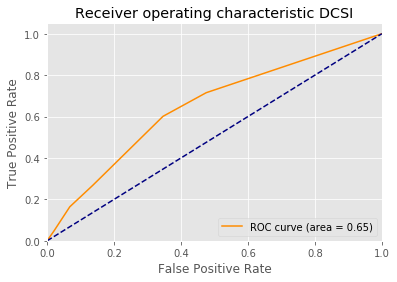

In [31]:
y_test = np.asarray(join_dcsi['Death'])
y_score= np.asarray(join_dcsi['DCSI'])
roc_plot(y_test,y_score)

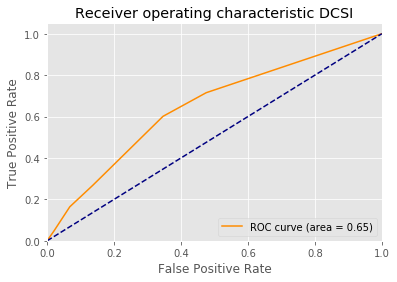

In [32]:
y_test = np.asarray(join_dcsi['Death']);
y_score= np.asarray(join_dcsi['DCSI']);


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic DCSI')
plt.legend(loc="lower right")
plt.show()

# ELIXHAUSER SCORE


We use SQL relation (ELIXHAUSER_QUAN_SCORE) created using SQL code from https://github.com/MIT-LCP/mimic-code

In [33]:
query = \
"""
SELECT *
FROM ELIXHAUSER_QUAN_SCORE;
"""

eli = pd.read_sql_query(query,con)



In [34]:
eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30
0,100001,5.0,5.0,6.0
1,100003,11.0,4.0,5.0
2,100006,11.0,11.0,22.0
3,100007,0.0,-1.0,-2.0
4,100009,-2.0,-2.0,5.0


In [35]:
join_eli = pd.merge(eli, data, how='inner', on=['hadm_id'])
join_eli.head()

,hadm_id,elixhauser_vanwalraven,elixhauser_sid29,elixhauser_sid30,subject_id,deathtime,age,gender,marital_status,admission_type,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,100001,5.0,5.0,6.0,58526,NaT,35.476452,F,DIVORCED,EMERGENCY,...,NaN,NaN,NaN,65.0,305.0,165.428571,1.9,2.7,2.214286,0
1,100003,11.0,4.0,5.0,54610,NaT,59.912739,M,SINGLE,EMERGENCY,...,NaN,NaN,NaN,56.0,135.0,96.833333,0.9,1.3,1.083333,0
2,100009,-2.0,-2.0,5.0,533,NaT,60.797126,M,MARRIED,EMERGENCY,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
3,100016,6.0,4.0,5.0,68591,NaT,55.512635,M,SINGLE,EMERGENCY,...,NaN,NaN,NaN,63.0,110.0,81.750000,1.0,1.2,1.112500,0
4,100018,18.0,26.0,36.0,58128,NaT,55.542455,M,MARRIED,ELECTIVE,...,NaN,NaN,NaN,54.0,224.0,134.133333,0.9,1.2,1.066667,0


## There are 3 type of elixhauser score, we then test all and choose the best score.

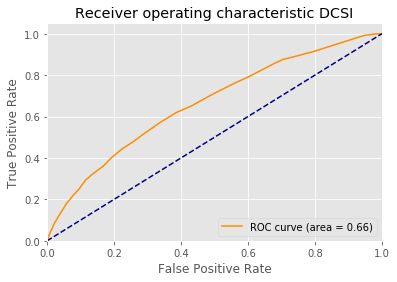

In [36]:
# Using elixhauser_vanwalraven
join_eli_vanwalraven= join_eli[['Death','elixhauser_vanwalraven']]
join_eli_vanwalraven=join_eli_vanwalraven.dropna()

y_test = np.asarray(join_eli_vanwalraven['Death'])
y_score= np.asarray(join_eli_vanwalraven['elixhauser_vanwalraven'])

roc_plot(y_test,y_score)

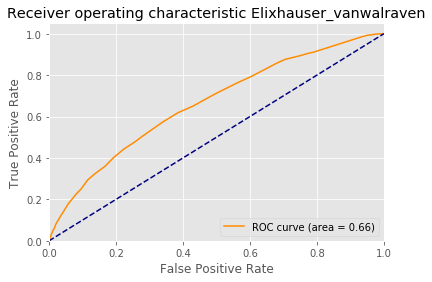

In [37]:
# Using elixhauser_vanwalraven

join_eli_vanwalraven= join_eli[['Death','elixhauser_vanwalraven']];
join_eli_vanwalraven=join_eli_vanwalraven.dropna()

y_test = np.asarray(join_eli_vanwalraven['Death']);
y_score= np.asarray(join_eli_vanwalraven['elixhauser_vanwalraven']);

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Elixhauser_vanwalraven')
plt.legend(loc="lower right")
plt.show()

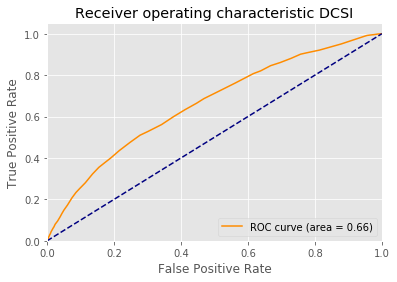

In [38]:
# Using elixhauser_29
join_eli_29= join_eli[['Death','elixhauser_sid29']]
join_eli_29=join_eli_29.dropna()

y_test = np.asarray(join_eli_29['Death'])
y_score= np.asarray(join_eli_29['elixhauser_sid29'])

roc_plot(y_test,y_score)

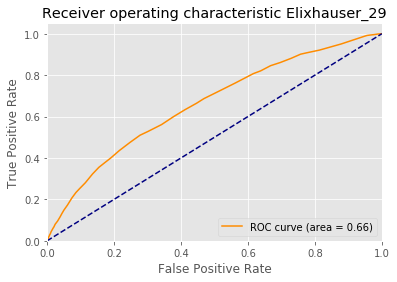

In [39]:
# Using elixhauser_29

join_eli_29= join_eli[['Death','elixhauser_sid29']];
join_eli_29=join_eli_29.dropna()

y_test = np.asarray(join_eli_29['Death']);
y_score= np.asarray(join_eli_29['elixhauser_sid29']);


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Elixhauser_29')
plt.legend(loc="lower right")
plt.show()

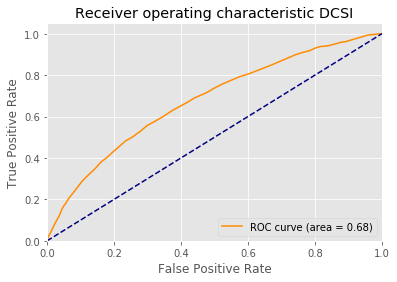

In [40]:
# Using elixhauser_30
join_eli_30= join_eli[['Death','elixhauser_sid30']]
join_eli_30=join_eli_30.dropna()

y_test = np.asarray(join_eli_30['Death'])
y_score= np.asarray(join_eli_30['elixhauser_sid30'])

roc_plot(y_test,y_score)

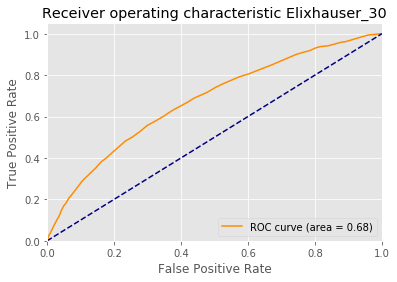

In [41]:
# Using elixhauser_30

join_eli_30= join_eli[['Death','elixhauser_sid30']];
join_eli_30=join_eli_30.dropna()

y_test = np.asarray(join_eli_30['Death']);
y_score= np.asarray(join_eli_30['elixhauser_sid30']);

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Elixhauser_30')
plt.legend(loc="lower right")
plt.show()

elixhauser_30 is the best score among the three

# Charlson comorbidity score (CCS)

We follow the proceduce in R code from https://cran.r-project.org/web/packages/comorbidity/vignettes/comorbidityscores.html to create the CCS score

## Using SQL query to create CCS category

In [42]:
query = \
"""

with
icd as
(
  select hadm_id, seq_num
    , cast(icd9_code as char(5)) as icd9_code
  from diagnoses_icd
)
,
eliflg as
(
select hadm_id, seq_num, icd9_code
-- note that these codes will seem incomplete at first
-- for example, CHF is missing a lot of codes referenced in the literature (402.11, 402.91, etc)
-- these codes are captured by hypertension flags instead
-- later there are some complicated rules which confirm/reject those codes as CHF
, CASE
  when icd9_code between '4100 ' and '4109 ' then 1
  when icd9_code between '4120 ' and '4129 ' then 1
    end as MI /* Myocardial infarction */      
, case
    when icd9_code = '39891' then 1
    when icd9_code = '40201' then 1
    when icd9_code = '40211' then 1
    when icd9_code = '40291' then 1
    when icd9_code = '40401' then 1
    when icd9_code = '40403' then 1
    when icd9_code = '40411' then 1
    when icd9_code = '40413' then 1
    when icd9_code = '40491' then 1
    when icd9_code = '40493' then 1
    when icd9_code between '4254 ' and '4259 ' then 1
    when icd9_code between '4280 ' and '4299 ' then 1
  end as CHF /* Congestive heart failure */

, CASE
    when icd9_code = '0930 ' then 1
    when icd9_code = '4373 ' then 1
    when icd9_code between '4400 ' and '4409 ' then 1
    when icd9_code between '4410 ' and '4419 ' then 1
    when icd9_code between '4431 ' and '4439 ' then 1
    when icd9_code = '4471 ' then 1
    when icd9_code = '5571 ' then 1
    when icd9_code = '5579 ' then 1
    when icd9_code = 'V434 ' then 1

end as PVD    /* Peripheral vascular disease */

, CASE
  when icd9_code = '36234' then 1
  when icd9_code between '4300 ' and '4389 ' then 1
end as CD  /* Cerebrovascular disease */

, CASE
  when icd9_code between '2900 ' and '2909 ' then 1
  when icd9_code = '2941 ' then 1
  when icd9_code = '3312 ' then 1
end as DT  /* Dementia */

, CASE
  when icd9_code = '4168 ' then 1
  when icd9_code = '4169 ' then 1
  when icd9_code between '4900 ' and '5059 ' then 1
  when icd9_code = '5064 ' then 1
  when icd9_code = '5081 ' then 1
  when icd9_code = '5088 ' then 1
end as CPD       /* Chronic pulmonary disease */

, CASE
  when icd9_code = '4465 ' then 1
  when icd9_code between '7100 ' and '7104 ' then 1
  when icd9_code between '7140 ' and '7142 ' then 1
  when icd9_code = '7148 ' then 1
  when icd9_code between '7250 ' and '7259 ' then 1
end as RHD     /* Rheumatic disease */


, CASE
  when icd9_code between '5310 ' and '5349 ' then 1
end as PUD   /* Peptic ulcer disease */

, CASE
  when icd9_code = '07022' then 1
  when icd9_code = '07023' then 1
  when icd9_code = '07032' then 1
  when icd9_code = '07033' then 1
  when icd9_code = '07044' then 1
  when icd9_code = '07054' then 1
  when icd9_code = '0706 ' then 1
  when icd9_code between '5700 ' and '5709 ' then 1
  when icd9_code between '5710 ' and '5719 ' then 1
  when icd9_code = '5733 ' then 1
  when icd9_code = '5734 ' then 1
  when icd9_code = '5738 ' then 1
  when icd9_code = '5739 ' then 1
  when icd9_code = 'V427' then 1
end as MLD  /* Mild liver disease */

, CASE
  when icd9_code between '2500 ' and '2503 ' then 1
  when icd9_code = '2508 ' then 1
  when icd9_code = '2509 ' then 1
end as DWOCC   /* Diabetes without chronic complication */

, CASE
  when icd9_code between '2504 ' and '2507 ' then 1
end as DWCC   /* Diabetes with chronic complication */



, CASE
  when icd9_code = '3341 ' then 1
  when icd9_code between '3420 ' and '3429 ' then 1
  when icd9_code between '3430 ' and '3439 ' then 1
  when icd9_code between '3440 ' and '3446 ' then 1
  when icd9_code = '3449 ' then 1
end as HOP  /* Hemiplegia or paraplegia */

, CASE
  when icd9_code = '40301' then 1
  when icd9_code = '40311' then 1
  when icd9_code = '40391' then 1
  when icd9_code = '40402' then 1
  when icd9_code = '40403' then 1
  when icd9_code = '40412' then 1
  when icd9_code = '40413' then 1
  when icd9_code = '40492' then 1
  when icd9_code = '40493' then 1
  when icd9_code between '5820 ' and '5829 ' then 1
  when icd9_code between '5830 ' and '5837 ' then 1
  when icd9_code between '5850 ' and '5859 ' then 1
  when icd9_code between '5860 ' and '5869 ' then 1
  when icd9_code = '5880 ' then 1
  when icd9_code = 'V420 ' then 1
  when icd9_code = 'V451 ' then 1
  when icd9_code between 'V560 ' and 'V569 ' then 1
end as RD   /* Renal disease */

, CASE
  when icd9_code between '1400 ' and '1729 ' then 1
  when icd9_code between '1740 ' and '1958 ' then 1
  when icd9_code between '2000 ' and '2089 ' then 1
  when icd9_code = '2386 ' then 1
end as AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

, CASE
  when icd9_code between '4560 ' and '4562 ' then 1
  when icd9_code between '5722 ' and '5728 ' then 1
end as MOSLD   /* Moderate or severe liver disease */

, CASE
  when icd9_code between '1960 ' and '1999 ' then 1
end as MST    /* Metastatic solid tumour */

, CASE
  when icd9_code between '0420 ' and '0449 ' then 1
end as HIV   /* AIDS/HIV */


from icd
)
-- collapse the icd9_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select hadm_id
  , max(MI) as MI
  , max(CHF) as CHF
  , max(PVD) as PVD
  , max(CD) as CD
  , max(DT) as DT
  , max(CPD) as CPD
  , max(RHD) as RHD
  , max(PUD) as PUD
  , max(MLD) as MLD
  , max(DWOCC) as DWOCC
  , max(DWCC) as DWCC
  , max(HOP) as HOP
  , max(RD) as RD
  , max(AM) as AM
  , max(MOSLD) as MOSLD
  , max(MST) as MST
  , max(HIV) as HIV

from eliflg
group by hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated
select adm.subject_id, adm.hadm_id
, case when MI = 1 then 1 else 0 end as MI
, case when CHF = 1 then 1 else 0 end as CHF
, case when PVD = 1 then 1 else 0 end as PVD
, case when CD = 1 then 1 else 0 end as CD
, case when DT = 1 then 1 else 0 end as DT
, case when CPD = 1 then 1 else 0 end as CPD
, case when RHD = 1 then 1 else 0 end as RHD
, case when PUD = 1 then 1 else 0 end as PUD
, case when MLD = 1 then 1 else 0 end as MLD
, case when DWOCC = 1 then 1 else 0 end as DWOCC
, case when DWCC = 1 then 1 else 0 end as DWCC
, case when HOP = 1 then 1 else 0 end as HOP
, case when RD = 1 then 1 else 0 end as RD
, case when AM = 1 then 1 else 0 end as AM
, case when MOSLD = 1 then 1 else 0 end as MOSLD
, case when MST = 1 then 1 else 0 end as MST
, case when HIV = 1 then 1 else 0 end as HIV


from admissions adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
order by adm.hadm_id;

"""

ccs = pd.read_sql_query(query,con)
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Definition of each column
MI /* Myocardial infarction */ 

CHF /* Congestive heart failure */

PVD    /* Peripheral vascular disease */

CD  /* Cerebrovascular disease */

DT  /* Dementia */

CPD       /* Chronic pulmonary disease */

RHD     /* Rheumatic disease */

PUD   /* Peptic ulcer disease */

MLD  /* Mild liver disease */

DWOCC   /* Diabetes without chronic complication */

DWCC   /* Diabetes with chronic complication */

HOP  /* Hemiplegia or paraplegia */

RD   /* Renal disease */

AM  /* Any malignancy, including lymphoma and leukaemia, except malignant neoplasm of skin */

MOSLD   /* Moderate or severe liver disease */

MST    /* Metastatic solid tumour */

HIV   /* AIDS/HIV */


In [43]:
# create the CCS score
def CCS_score(df):
    score = 0 ;
    score = score + df['mi']+df['chf']+df['pvd']+df['cd']+df['dt']+df['cpd']+df['rhd']+df['mld']+df['dwocc'];
    score = score + 2*(df['dwcc']+df['hop']+df['rd']+df['am'])
    score = score + 3*(df['mosld'])
    score = score + 6*(df['mst']+df['hiv'])

    
    return score

ccs['CCS'] = ccs.apply(CCS_score, axis=1)

In [44]:
ccs.head()

,subject_id,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,mld,dwocc,dwcc,hop,rd,am,mosld,mst,hiv,CCS
0,58526,100001,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,5
1,54610,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
2,9895,100006,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
3,23018,100007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,533,100009,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2


In [45]:
join_ccs = pd.merge(ccs, data, how='inner', on=['hadm_id'])
join_ccs.head()

,subject_id_x,hadm_id,mi,chf,pvd,cd,dt,cpd,rhd,pud,...,hba1c_min,hba1c_max,hba1c_mean,lab_glucose_min,lab_glucose_max,lab_glucose_mean,serum_creatinine_min,serum_creatinine_max,serum_creatinine_mean,Death
0,58526,100001,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,65.0,305.0,165.428571,1.9,2.7,2.214286,0
1,54610,100003,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,56.0,135.0,96.833333,0.9,1.3,1.083333,0
2,533,100009,0,0,1,0,0,0,0,0,...,7.9,7.9,7.9,151.0,263.0,198.800000,0.7,0.8,0.783333,0
3,68591,100016,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,63.0,110.0,81.750000,1.0,1.2,1.112500,0
4,58128,100018,0,1,1,1,0,1,0,0,...,NaN,NaN,NaN,54.0,224.0,134.133333,0.9,1.2,1.066667,0


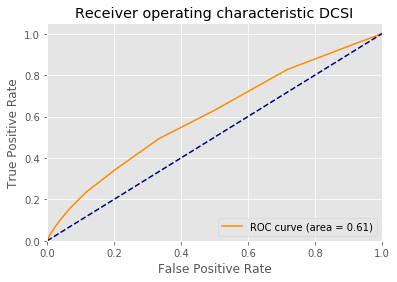

In [46]:
# Using ccs
y_test = np.asarray(join_ccs['Death'])
y_score= np.asarray(join_ccs['CCS'])

roc_plot(y_test,y_score)

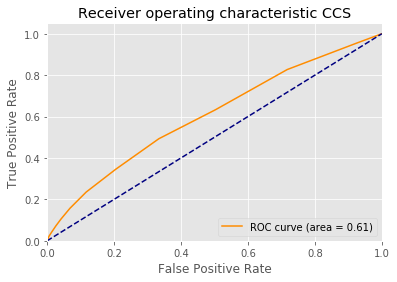

In [47]:
# Using ccs

y_test = np.asarray(join_ccs['Death']);
y_score= np.asarray(join_ccs['CCS']);


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic CCS')
plt.legend(loc="lower right")
plt.show()

# Join all

In [48]:
eli_30 = eli[['hadm_id','elixhauser_sid30']];

In [49]:
data_drop = data.drop(['subject_id','deathtime',], axis=1)

In [50]:
data_drop = data_drop.drop(['hba1c_min','hba1c_max','lab_glucose_min','lab_glucose_max','serum_creatinine_min','serum_creatinine_max',], axis=1)

In [51]:

join_dcsi = pd.merge(dcsi_score, data_drop, how='inner', on=['hadm_id'])
join_dcsi = join_dcsi.drop_duplicates()

eli_30 = eli[['hadm_id','elixhauser_sid30']];
join_eli = pd.merge(eli_30, join_dcsi, how='inner', on=['hadm_id'])

ccs_score = ccs[['hadm_id','CCS']];
join_total = pd.merge(ccs_score, join_eli, how='inner', on=['hadm_id'])

join_total = join_total.drop('hadm_id', axis=1)


# Exploratory Data Analysis

In [52]:
def pie_chart(labels, sizes, colors):
    plt.pie(sizes, labels=labels, colors=colors)
    plt.axis('equal')
    plt.show()
    return

In [53]:
def plot_hist(dataset, index):
    df_hist = []
    l = int(len(dataset)/2)
    for n in range (l):
        df_hist.append([x for i,x in enumerate(dataset) if i%l==n])
    df_hist = np.array(df_hist)
    df_hist = pd.DataFrame(df_hist, index = index, columns = ['Death=0', 'Death=1'])
    df_hist.plot(kind = 'bar', ylim = [0, max(dataset)+1000], rot=0)
    return

In [54]:
cut_bins = [0, 50, 60, 70, 80,float("inf")]

df_temp = join_total[['age','Death']]
cut_frame = pd.cut(df_temp['age'], bins=cut_bins)

df_temp ["age_range"] = cut_frame

df_temp = df_temp.groupby('Death')["age_range"]
counts = df_temp.value_counts(sort=False)
percentage100 = df_temp.value_counts(normalize = True,sort=False).mul(100).round(1).astype(str)+'%'

#percentage100 = df_temp.transform(lambda x: pd.cut(x, bins=cut_bins).value_counts()).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
a = np.array(df_show['counts'])
df_show


counts percentages
Death age_range                       
0     (0.0, 50.0]     2668       14.3%
      (50.0, 60.0]    3330       17.9%
      (60.0, 70.0]    4614       24.7%
      (70.0, 80.0]    4393       23.6%
      (80.0, inf]     3648       19.6%
1     (0.0, 50.0]      156        7.0%
      (50.0, 60.0]     289       12.9%
      (60.0, 70.0]     465       20.8%
      (70.0, 80.0]     570       25.5%
      (80.0, inf]      756       33.8%

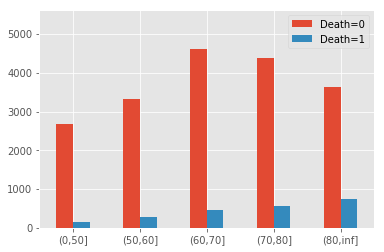

In [55]:
index = ['(0,50]','(50,60]','(60,70]','(70,80]','(80,inf]']
plot_hist(a, index)
#df_hist = np.matrix('2668, 156; 3330, 289; 4614, 465; 4393, 570; 3648, 756')
#df_hist = np.array([[x for i,x in enumerate(a) if i%5==0], [x for i,x in enumerate(a) if i%5==1], [x for i,x in enumerate(a) if i%5==2], [x for i,x in enumerate(a) if i%5==3], [x for i,x in enumerate(a) if i%5==4]])
#df_hist = pd.DataFrame(df_hist, index = index, columns = ['Death=0', 'Death=1'])
#df_hist.plot(kind = 'bar', ylim = [0, 5000], rot=0)

In [56]:
df_temp = join_total.groupby('Death')['gender']
counts = df_temp.value_counts()
percentage100 = df_temp.value_counts(normalize = True).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
df_show


counts percentages
Death gender                    
0     M         9560       51.3%
      F         9093       48.7%
1     M         1166       52.1%
      F         1070       47.9%

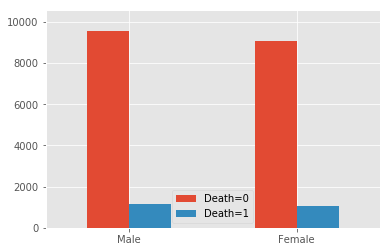

In [57]:
index = ['Male', 'Female']
plot_hist(np.array(df_show['counts']), index)

In [58]:
df_temp=join_total.groupby('Death')['marital_status']
counts = df_temp.value_counts()
percentage100 = df_temp.value_counts(normalize = True).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
df_show


counts percentages
Death marital_status                       
0     MARRIED              8862       48.8%
      SINGLE               4625       25.4%
      WIDOWED              2975       16.4%
      DIVORCED             1347        7.4%
      SEPARATED             257        1.4%
      UNKNOWN (DEFAULT)     108        0.6%
      LIFE PARTNER            3        0.0%
1     MARRIED              1016       48.9%
      WIDOWED               466       22.4%
      SINGLE                417       20.1%
      DIVORCED              129        6.2%
      SEPARATED              28        1.3%
      UNKNOWN (DEFAULT)      21        1.0%

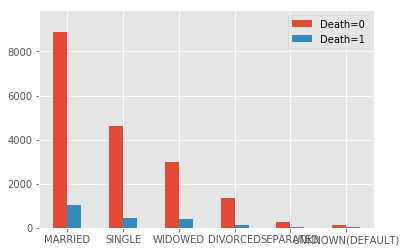

In [59]:
a = np.array(df_show['counts'])
l = a.tolist()
l.remove(3)
a = np.array(l)
index = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED','SEPARATED','UNKNOWN(DEFAULT)']
plot_hist(a, index)

In [60]:
df_temp=join_total.groupby('Death')['admission_type']
counts = df_temp.value_counts()
percentage100 = df_temp.value_counts(normalize = True).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
df_show

counts percentages
Death admission_type                    
0     EMERGENCY        15715       84.2%
      ELECTIVE          2488       13.3%
      URGENT             442        2.4%
      NEWBORN              8        0.0%
1     EMERGENCY         2128       95.2%
      ELECTIVE            67        3.0%
      URGENT              41        1.8%

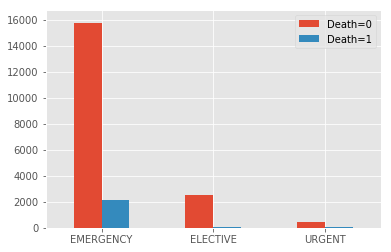

In [61]:
a = np.array(df_show['counts'])
l = a.tolist()
l.remove(8)
a = np.array(l)
index = ['EMERGENCY', 'ELECTIVE', 'URGENT']
plot_hist(a, index)

In [62]:
df_temp = join_total.groupby('Death')['ethnicity']
counts = df_temp.value_counts()
percentage100 = df_temp.value_counts(normalize = True).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
df_show

counts percentages
Death ethnicity                                                    
0     WHITE                                       12877       69.0%
      BLACK/AFRICAN AMERICAN                       2427       13.0%
      UNKNOWN/NOT SPECIFIED                        1120        6.0%
      HISPANIC OR LATINO                            511        2.7%
      OTHER                                         389        2.1%
...                                                 ...         ...
1     ASIAN - JAPANESE                                1        0.0%
      HISPANIC/LATINO - DOMINICAN                     1        0.0%
      MIDDLE EASTERN                                  1        0.0%
      NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       1        0.0%
      PORTUGUESE                                      1        0.0%

[66 rows x 2 columns]

In [63]:
df_temp=join_total.groupby('Death')['insurance']
counts = df_temp.value_counts()
percentage100 = df_temp.value_counts(normalize = True).mul(100).round(1).astype(str)+'%'
df_show = pd.DataFrame({'counts':counts,'percentages':percentage100})
df_show

counts percentages
Death insurance                     
0     Medicare     11816       63.3%
      Private       4774       25.6%
      Medicaid      1602        8.6%
      Government     380        2.0%
      Self Pay        81        0.4%
1     Medicare      1639       73.3%
      Private        411       18.4%
      Medicaid       147        6.6%
      Government      23        1.0%
      Self Pay        16        0.7%

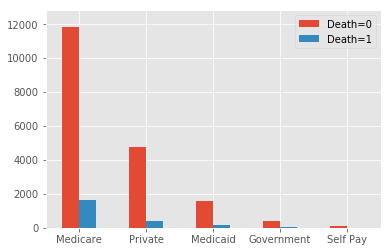

In [64]:
index = ['Medicare', 'Private','Medicaid','Government','Self Pay']
plot_hist(np.array(df_show['counts']), index)

In [65]:
numeric_mean = join_total.groupby('Death').mean().round(2).astype(str)
numeric_mean

,CCS,elixhauser_sid30,DCSI,age,hba1c_mean,lab_glucose_mean,serum_creatinine_mean
Death,,,,,,,
0,2.96,14.5,1.05,76.24,7.43,144.17,1.62
1,3.91,23.17,1.81,93.17,6.85,160.22,2.06


In [66]:
numeric_std = join_total.groupby('Death').std().mul(1).round(2).astype(str)
numeric_std

,CCS,elixhauser_sid30,DCSI,age,hba1c_mean,lab_glucose_mean,serum_creatinine_mean
Death,,,,,,,
0,2.18,12.84,1.35,52.45,2.16,45.75,1.67
1,2.68,14.15,1.53,70.68,1.48,60.2,1.53


In [67]:
numeric_value = numeric_mean+"\u00B1"+numeric_std
numeric_value

,CCS,elixhauser_sid30,DCSI,age,hba1c_mean,lab_glucose_mean,serum_creatinine_mean
Death,,,,,,,
0,2.96±2.18,14.5±12.84,1.05±1.35,76.24±52.45,7.43±2.16,144.17±45.75,1.62±1.67
1,3.91±2.68,23.17±14.15,1.81±1.53,93.17±70.68,6.85±1.48,160.22±60.2,2.06±1.53


In [68]:
numeric_value = pd.melt(numeric_value.reset_index(),id_vars=["Death"], 
        var_name="Data type", 
        value_name="Mean \u00B1 SD")
numeric_value


,Death,Data type,Mean ± SD
0,0,CCS,2.96±2.18
1,1,CCS,3.91±2.68
2,0,elixhauser_sid30,14.5±12.84
3,1,elixhauser_sid30,23.17±14.15
4,0,DCSI,1.05±1.35
5,1,DCSI,1.81±1.53
6,0,age,76.24±52.45
7,1,age,93.17±70.68
8,0,hba1c_mean,7.43±2.16
9,1,hba1c_mean,6.85±1.48


## Convert category to numeric

In [69]:
cat_columns = join_total.select_dtypes(['object']).columns
cat_columns

join_total[cat_columns] = join_total[cat_columns].apply(lambda x: x.astype('category').cat.codes)


In [70]:
join_total.isnull().sum()

CCS                          0
elixhauser_sid30            15
DCSI                         0
age                          0
gender                       0
marital_status               0
admission_type               0
ethnicity                    0
insurance                    0
hba1c_mean               17494
lab_glucose_mean             0
serum_creatinine_mean        2
Death                        0
dtype: int64

# Modeling

We use 2 approaches to tackle problem of NaN for HbA1c data. 

1) We build a model for each dataset that have and don't have HbA1c data and combine them assuming the same signficance.

2) We turn HbA1c data into categerical in order to be able to include NaN as one of its label.

All of the model are evaluated using 10-fold cross validation

## Model on data that have HbA1


(3393, 12)


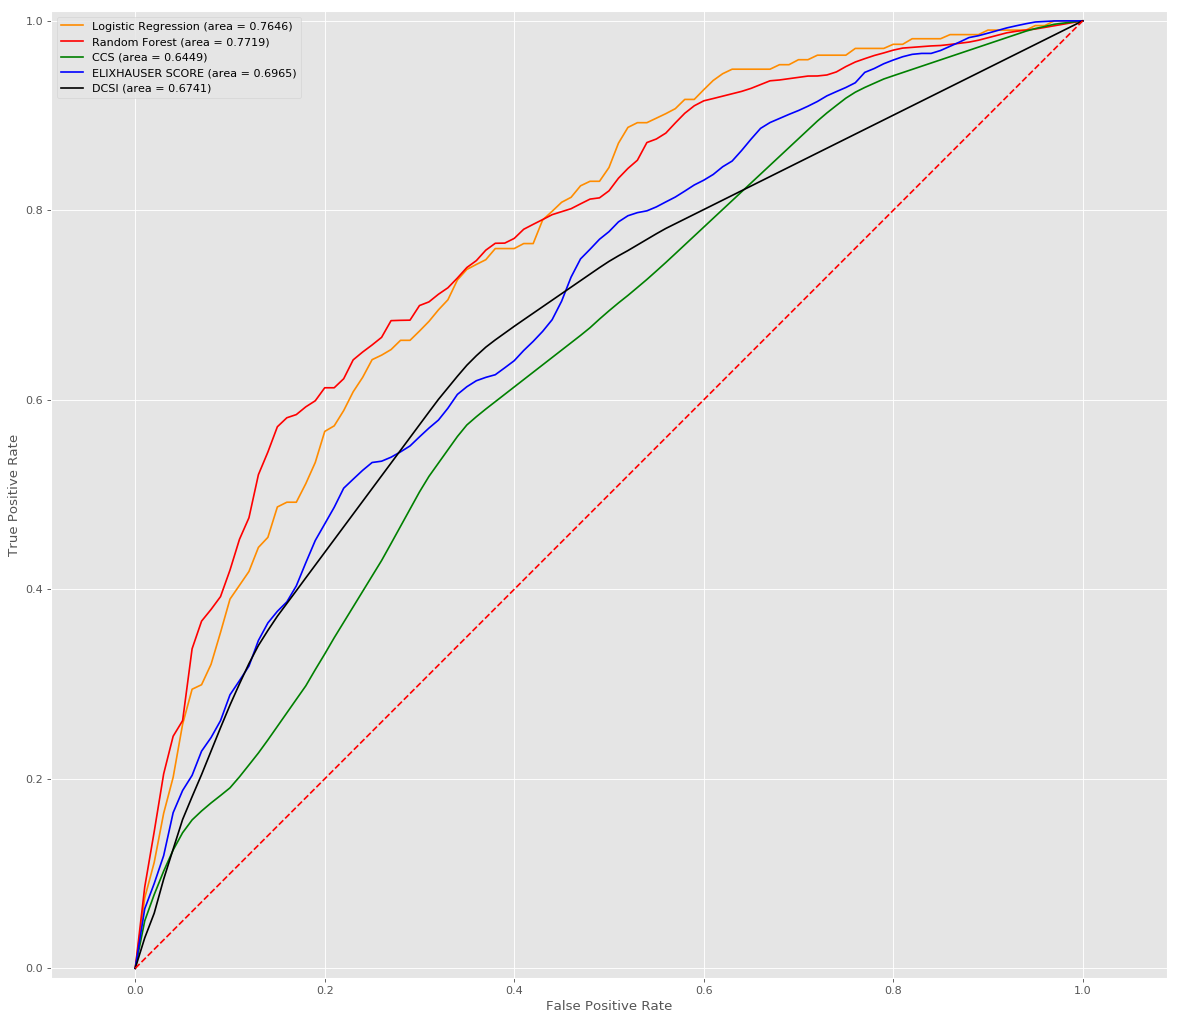

In [71]:

random.seed(2020)

X = join_total.dropna().drop('Death', axis=1).values;

y = join_total.dropna()['Death'].values

print(X.shape)

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
auc_logistic_not_na=[];
auc_ccs_not_na=[];
auc_eli_not_na=[];
auc_dcsi_not_na=[];
auc_RF_not_na=[];

base_fpr = np.linspace(0, 1, 101)
tprs_logistic_not_na = [];
tprs_ccs_not_na = [];
tprs_eli_not_na = [];
tprs_dcsi_not_na = [];
tprs_RF_not_na = [];


fpr_avg =[];
tpr_avg =[];

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    modelRF = RandomForestClassifier(n_estimators=500,bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced')
    model = LogisticRegression(penalty='l2',solver='liblinear', class_weight = 'balanced')
    model.fit(X_train,y_train)
    modelRF.fit(X_train,y_train)

    #evaluate the model
    y_predict = model.predict_proba(X_test)[:,1]
    y_predictRF = modelRF.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)
    auc_logistic_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_logistic_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_predictRF)
    roc_auc = auc(fpr, tpr)
    auc_RF_not_na.append(roc_auc)
    
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_RF_not_na.append(tpr)
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,0])
    roc_auc = auc(fpr, tpr)
    auc_ccs_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_ccs_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_eli_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_eli_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,2])
    roc_auc = auc(fpr, tpr)
    auc_dcsi_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_dcsi_not_na.append(tpr)

    
tprs_RF = np.array(tprs_RF_not_na)
mean_tprs_RF = tprs_RF.mean(axis=0)
roc_auc_RF = auc(base_fpr, mean_tprs_RF)    
    
    
tprs_logistic = np.array(tprs_logistic_not_na)
mean_tprs_logistic = tprs_logistic.mean(axis=0)
roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

tprs_ccs = np.array(tprs_ccs_not_na)
mean_tprs_ccs = tprs_ccs.mean(axis=0)
roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

tprs_eli = np.array(tprs_eli_not_na)
mean_tprs_eli = tprs_eli.mean(axis=0)
roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

tprs_dcsi = np.array(tprs_dcsi_not_na)
mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)


#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)

plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

We have found that even though Random forest (RF) and Logistic Regression (LR) have the same performace (AUC is relatively similar). There are some area where RF is better than LR (False postive 0 - 0.4) and LR is better than RF (False postive 0.4 - 1.0). So, we think it is a good idea to do ensemble method. We choose stacking ensemble.

# Implementing p-value of coefficient in Logistic Regression

In [72]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
    def predict_proba(self,X):
        return self.model.predict_proba(X)
    def get_p_values(self):
        return self.p_values
    def get_coef(self):
        return self.model.coef_[0]

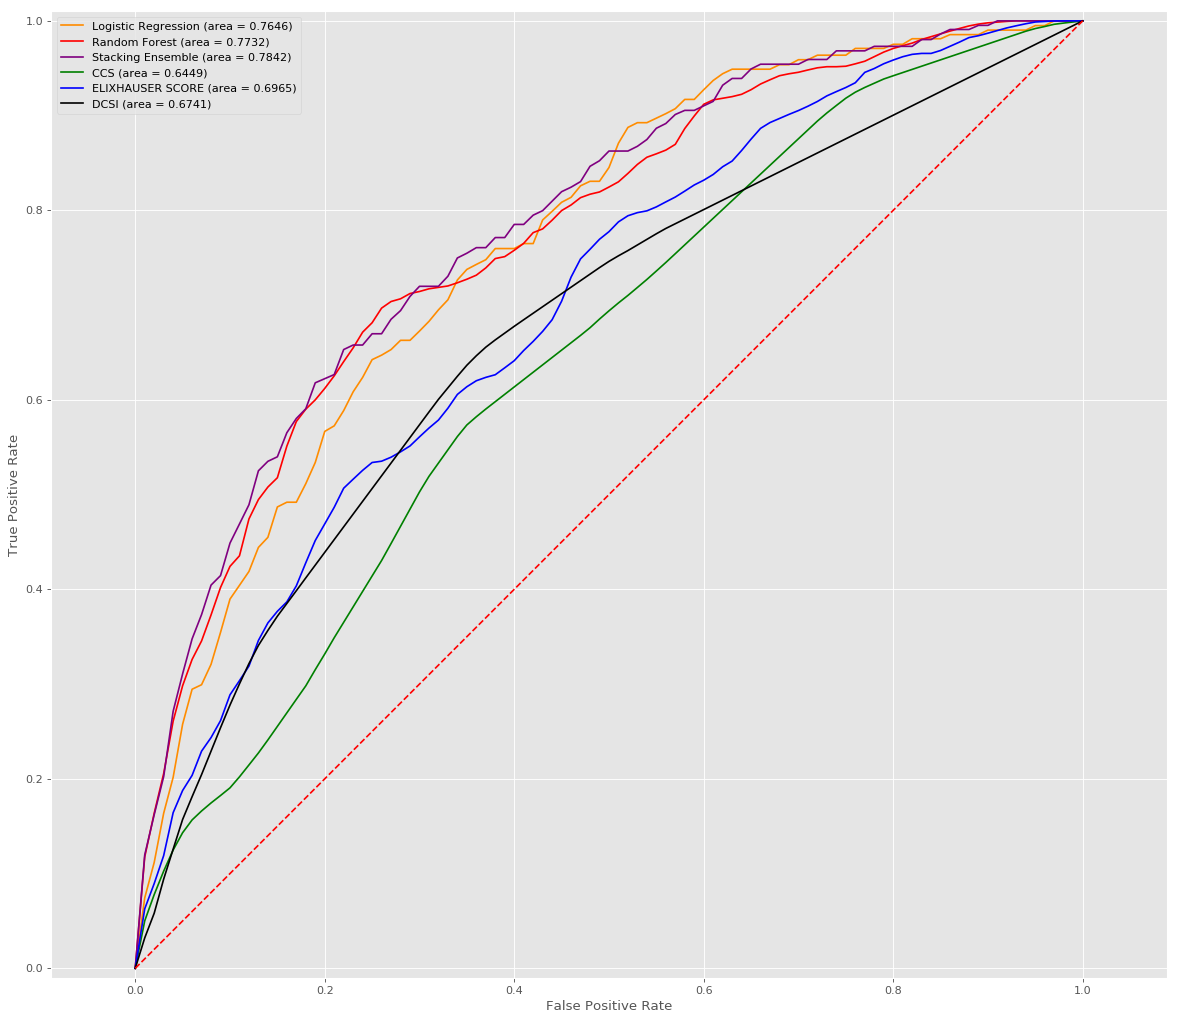

In [87]:

random.seed(2020)
X = join_total.dropna().drop('Death', axis=1).values;

y = join_total.dropna()['Death'].values

auc_logistic_not_na=[];
auc_ccs_not_na=[];
auc_eli_not_na=[];
auc_dcsi_not_na=[];
auc_RF_not_na=[];
auc_stack_not_na=[];

base_fpr = np.linspace(0, 1, 101)
tprs_logistic_not_na = [];
tprs_ccs_not_na = [];
tprs_eli_not_na = [];
tprs_dcsi_not_na = [];
tprs_RF_not_na = [];
tprs_stack_not_na = [];

fpr_avg =[];
tpr_avg =[];

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    modelRF = RandomForestClassifier(n_estimators=500,bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced')
    model = LogisticReg(penalty='l2',solver='liblinear', class_weight = 'balanced')
    model.fit(X_train,y_train)
    modelRF.fit(X_train,y_train)

    y_train_predict = model.predict_proba(X_train)[:,1]
    y_train_predictRF = modelRF.predict_proba(X_train)[:,1]
    
    y_train_predict = y_train_predict[...,None]
    y_train_predictRF = y_train_predictRF[...,None]
    
    stack_predict_train = np.concatenate((y_train_predict, y_train_predictRF),axis=1)
    model_stack = LogisticRegression();
    
    model_stack.fit(stack_predict_train,y_train)
    
    
    #evaluate the model
    y_predict = model.predict_proba(X_test)[:,1]
    y_predictRF = modelRF.predict_proba(X_test)[:,1]
    
    y_predict = y_predict[...,None]
    y_predictRF = y_predictRF[...,None]
    
    stack_predict_test = np.concatenate((y_predict, y_predictRF),axis=1)
    
    y_stack_predict = model_stack.predict_proba(stack_predict_test)[:,1]
    
    
    fpr, tpr, _ = roc_curve(y_test, y_stack_predict)
    roc_auc = auc(fpr, tpr)
    auc_stack_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_stack_not_na.append(tpr)

    
    

    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)
    auc_logistic_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_logistic_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_predictRF)
    roc_auc = auc(fpr, tpr)
    auc_RF_not_na.append(roc_auc)
    
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_RF_not_na.append(tpr)
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,0])
    roc_auc = auc(fpr, tpr)
    auc_ccs_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_ccs_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_eli_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_eli_not_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,2])
    roc_auc = auc(fpr, tpr)
    auc_dcsi_not_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_dcsi_not_na.append(tpr)

    
    
tprs_stack = np.array(tprs_stack_not_na)
mean_tprs_stack = tprs_stack.mean(axis=0)
roc_auc_stack = auc(base_fpr, mean_tprs_stack)       

    
tprs_RF = np.array(tprs_RF_not_na)
mean_tprs_RF = tprs_RF.mean(axis=0)
roc_auc_RF = auc(base_fpr, mean_tprs_RF)    
    
    
tprs_logistic = np.array(tprs_logistic_not_na)
mean_tprs_logistic = tprs_logistic.mean(axis=0)
roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

tprs_ccs = np.array(tprs_ccs_not_na)
mean_tprs_ccs = tprs_ccs.mean(axis=0)
roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

tprs_eli = np.array(tprs_eli_not_na)
mean_tprs_eli = tprs_eli.mean(axis=0)
roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

tprs_dcsi = np.array(tprs_dcsi_not_na)
mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)


#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)
plt.plot(base_fpr, mean_tprs_stack, 'purple', label='Stacking Ensemble (area = %0.4f)' % roc_auc_stack)

plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

We found that using ensemble method improve the overall performance

# Coeffience and P value

In [89]:
p_values_round=["%.4f" % round(x, 4) for x in model.get_p_values()]
feature = list(join_total.columns[:-1])
df_show = pd.DataFrame({'Features':feature ,'Coefficient':list(model.get_coef()),'P values':p_values_round})
df_show

,Features,Coefficient,P values
0,CCS,0.037305,0.1481
1,elixhauser_sid30,0.048220,0.0000
2,DCSI,0.292533,0.0000
3,age,0.003354,0.0004
4,gender,-0.312937,0.0003
5,marital_status,-0.009322,0.6817
6,admission_type,0.274133,0.0029
7,ethnicity,0.005047,0.2576
8,insurance,0.145075,0.0109
9,hba1c_mean,-0.333125,0.0000


## Plot L1 penalty to see what coeffiences are important

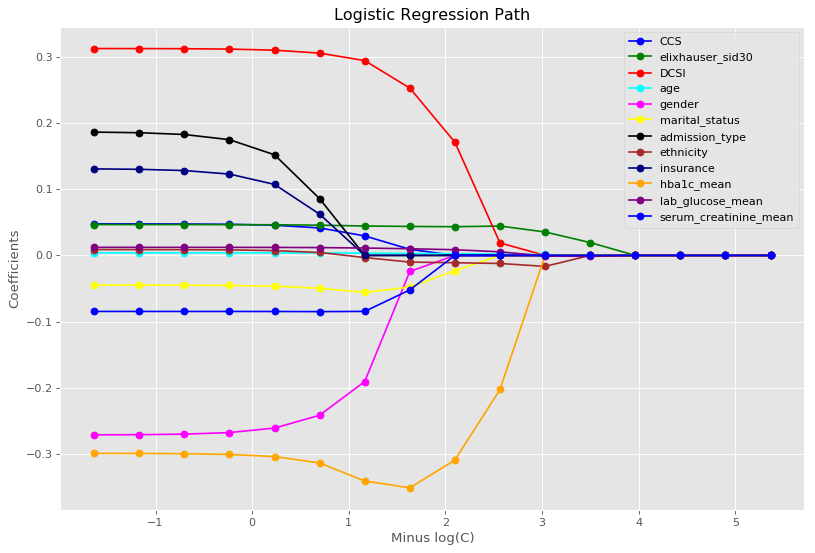

In [90]:
from sklearn.svm import l1_min_c
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)
clf = LogisticRegression(penalty='l1',solver='liblinear', class_weight = 'balanced')
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
    
coefs_ = np.array(coefs_)

fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
feature = list(join_total.columns[:-1])
ax = plt.subplot(111)
ax.set_prop_cycle('color',['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'navy', 'orange', 'purple'])
plt.plot(-np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('Minus log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.legend(feature)
plt.axis('tight')
plt.show()

We have found that DCSI, HbA1c mean and gender are the top three most important coefficients.

## Model on data that don't have HbA1


(17479, 11)


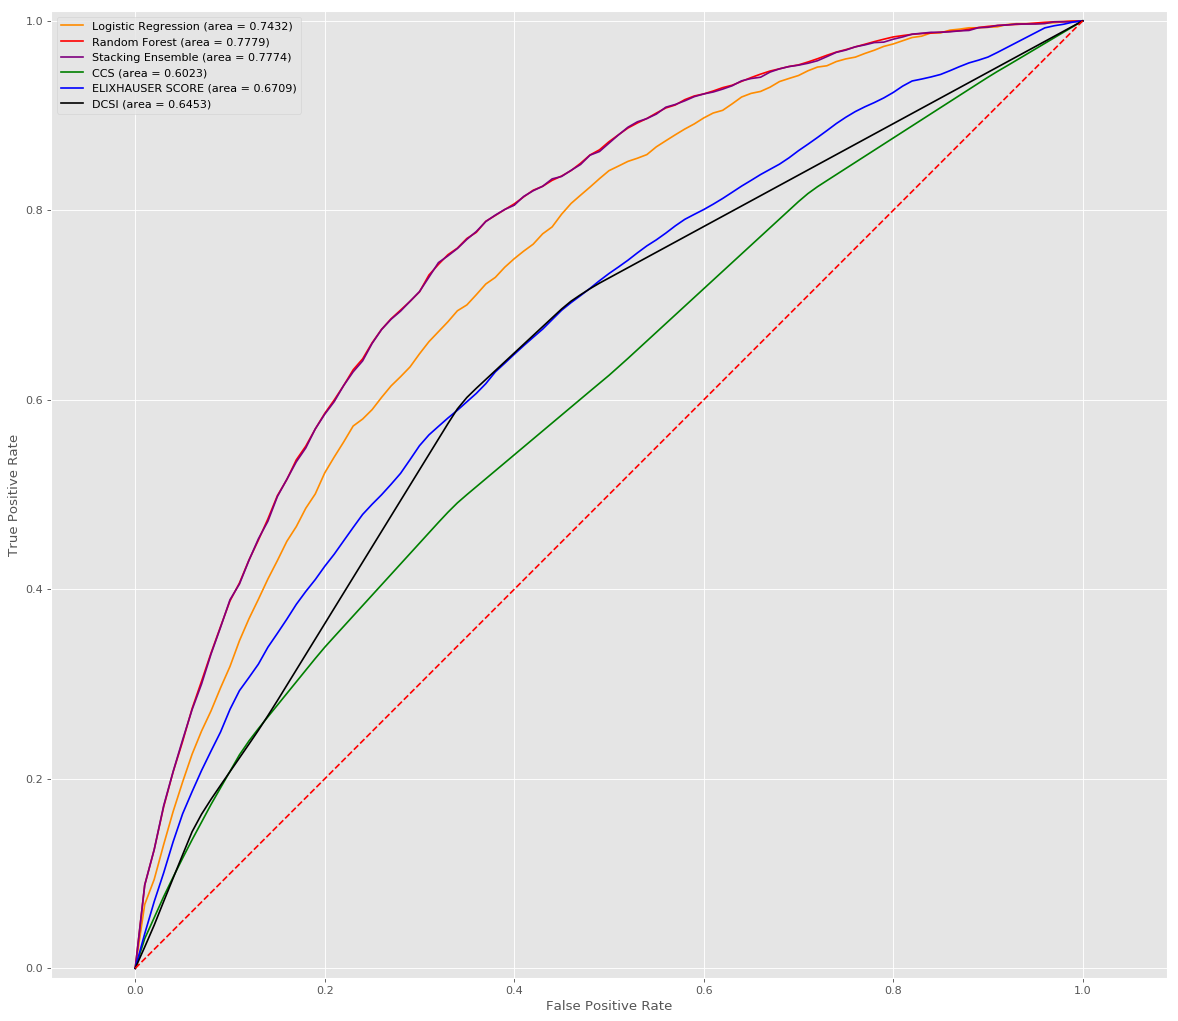

In [91]:

random.seed(2020)

join_total_NaHb =join_total[join_total['hba1c_mean'].isna()]
join_total_NaHb = join_total_NaHb.drop('hba1c_mean', axis=1)



X = join_total_NaHb.dropna().drop('Death', axis=1).values;

y = join_total_NaHb.dropna()['Death'].values

print(X.shape)

auc_logistic_na=[];
auc_ccs_na=[];
auc_eli_na=[];
auc_dcsi_na=[];
auc_RF_na=[];
auc_stack_na=[];

base_fpr = np.linspace(0, 1, 101)
tprs_logistic_na = [];
tprs_ccs_na = [];
tprs_eli_na = [];
tprs_dcsi_na = [];
tprs_RF_na = [];
tprs_stack_na = [];

fpr_avg =[];
tpr_avg =[];

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    modelRF = RandomForestClassifier(n_estimators=500,bootstrap = True,
                               max_features = 'sqrt',class_weight='balanced')
    model = LogisticReg(penalty='l2',solver='liblinear', class_weight = 'balanced')
    model.fit(X_train,y_train)
    modelRF.fit(X_train,y_train)

    y_train_predict = model.predict_proba(X_train)[:,1]
    y_train_predictRF = modelRF.predict_proba(X_train)[:,1]
    
    y_train_predict = y_train_predict[...,None]
    y_train_predictRF = y_train_predictRF[...,None]
    
    stack_predict_train = np.concatenate((y_train_predict, y_train_predictRF),axis=1)
    model_stack = LogisticRegression();
    
    model_stack.fit(stack_predict_train,y_train)
    
    
    #evaluate the model
    y_predict = model.predict_proba(X_test)[:,1]
    y_predictRF = modelRF.predict_proba(X_test)[:,1]
    
    y_predict = y_predict[...,None]
    y_predictRF = y_predictRF[...,None]
    
    stack_predict_test = np.concatenate((y_predict, y_predictRF),axis=1)
    
    y_stack_predict = model_stack.predict_proba(stack_predict_test)[:,1]
    
    
    fpr, tpr, _ = roc_curve(y_test, y_stack_predict)
    roc_auc = auc(fpr, tpr)
    auc_stack_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_stack_na.append(tpr)

    
    

    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr, tpr)
    auc_logistic_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_logistic_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_predictRF)
    roc_auc = auc(fpr, tpr)
    auc_RF_na.append(roc_auc)
    
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_RF_na.append(tpr)
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,0])
    roc_auc = auc(fpr, tpr)
    auc_ccs_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_ccs_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,1])
    roc_auc = auc(fpr, tpr)
    auc_eli_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_eli_na.append(tpr)
    
    
    fpr, tpr, _ = roc_curve(y_test, X_test[:,2])
    roc_auc = auc(fpr, tpr)
    auc_dcsi_na.append(roc_auc)
    
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_dcsi_na.append(tpr)

    
    
tprs_stack = np.array(tprs_stack_na)
mean_tprs_stack = tprs_stack.mean(axis=0)
roc_auc_stack = auc(base_fpr, mean_tprs_stack)       

    
tprs_RF = np.array(tprs_RF_na)
mean_tprs_RF = tprs_RF.mean(axis=0)
roc_auc_RF = auc(base_fpr, mean_tprs_RF)    
    
    
tprs_logistic = np.array(tprs_logistic_na)
mean_tprs_logistic = tprs_logistic.mean(axis=0)
roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

tprs_ccs = np.array(tprs_ccs_na)
mean_tprs_ccs = tprs_ccs.mean(axis=0)
roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

tprs_eli = np.array(tprs_eli_na)
mean_tprs_eli = tprs_eli.mean(axis=0)
roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

tprs_dcsi = np.array(tprs_dcsi_na)
mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)


#std = tprs.std(axis=0)

#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)
plt.plot(base_fpr, mean_tprs_stack, 'purple', label='Stacking Ensemble (area = %0.4f)' % roc_auc_stack)

plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

RF is better than LR in almost overall range (False positive 0 - 1.0), so the stacking ensemble method is not so efficient.

# Coeffience and P value

In [92]:
p_values_round=["%.4f" % round(x, 4) for x in model.get_p_values()]
feature = list(join_total_NaHb.columns[:-1])
df_show = pd.DataFrame({'Features':feature ,'Coefficient':list(model.get_coef()),'P values':p_values_round})
df_show

,Features,Coefficient,P values
0,CCS,0.010181,0.2681
1,elixhauser_sid30,0.042566,0.0000
2,DCSI,0.274025,0.0000
3,age,0.003894,0.0000
4,gender,-0.096925,0.0075
5,marital_status,-0.061157,0.0000
6,admission_type,0.543997,0.0000
7,ethnicity,0.018882,0.0000
8,insurance,-0.091851,0.0004
9,lab_glucose_mean,0.007618,0.0000


## Plot L1 penalty to see what coeffiences are important

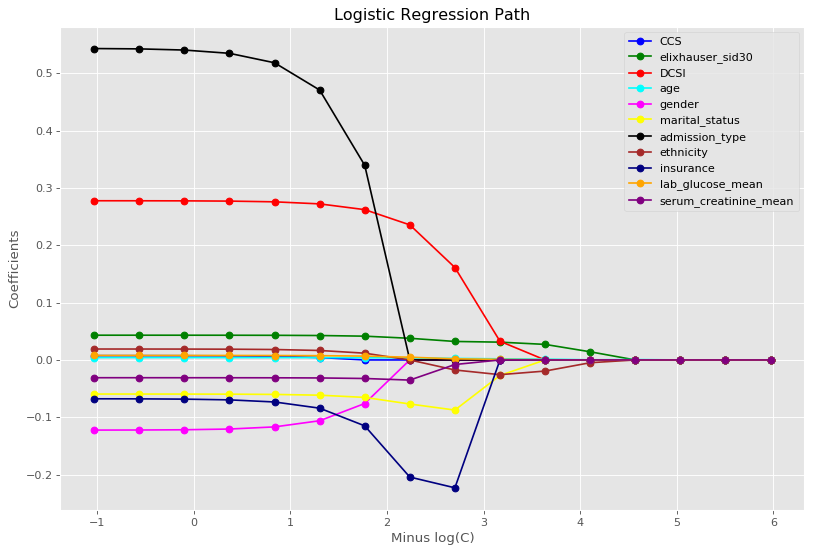

In [93]:
from sklearn.svm import l1_min_c
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)
clf = LogisticRegression(penalty='l1',solver='liblinear', class_weight = 'balanced')
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
feature = list(join_total_NaHb.columns[:-1])
ax = plt.subplot(111)
ax.set_prop_cycle('color',['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'navy', 'orange', 'purple'])
plt.plot(-np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('Minus log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.legend(feature)
plt.axis('tight')
plt.show()

We have found that admission type is the most important coeffient among the dataset where HbA1c record is absent.  This could be the result that RF works better with categorical data.

The top three coefficients are admission, insurance and DCSI. We notice that gender are disregarded which may be explained by the more population in NaN HbA1c dataset.

# Combine the model from Not having HbA1c and Having HbA1c

We combine the performace giving the same significance for each model.

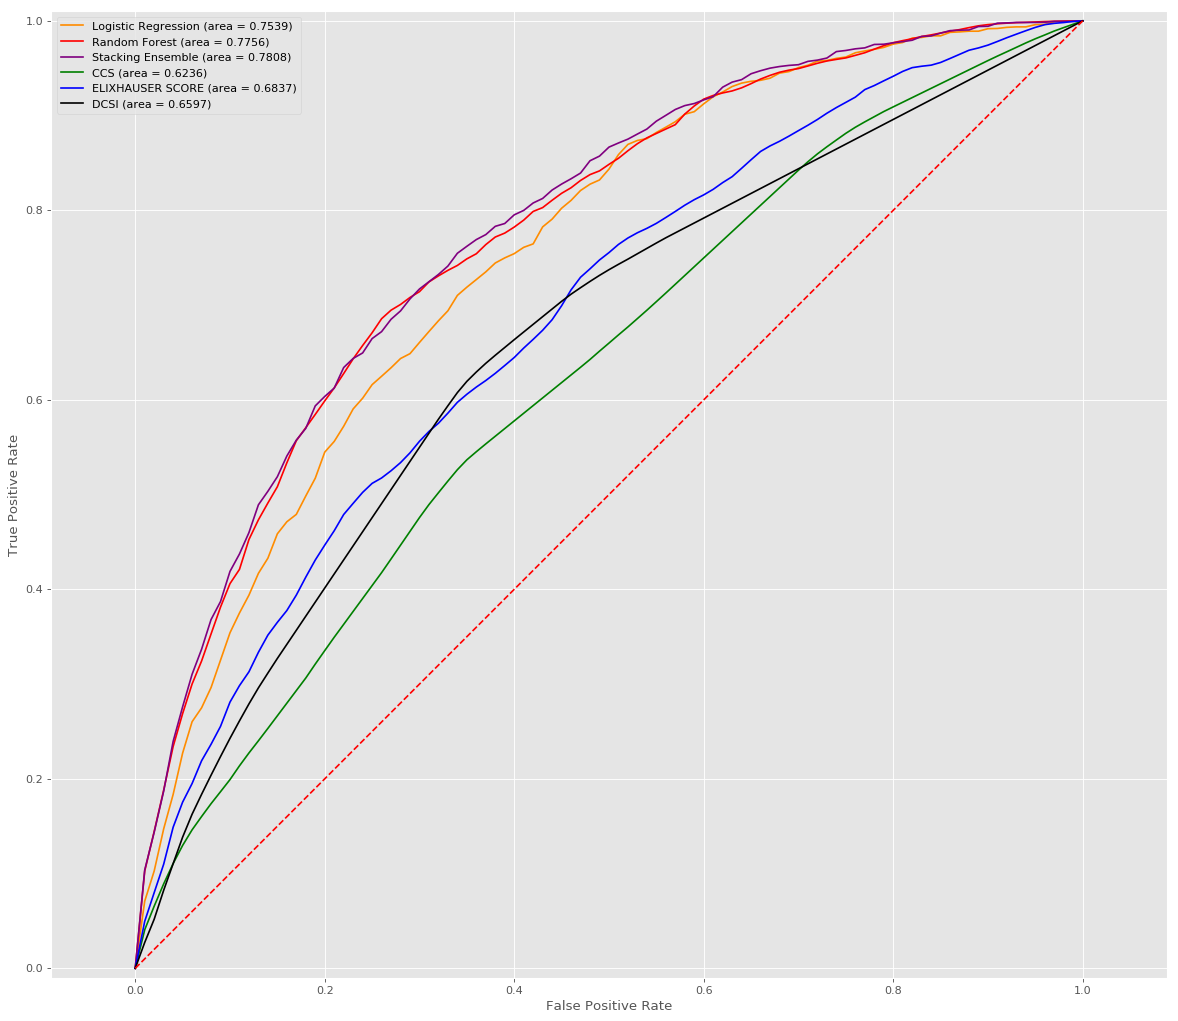

In [94]:
tprs_stack_all = tprs_stack_na + tprs_stack_not_na

tprs_stack = np.array(tprs_stack_all)
mean_tprs_stack = tprs_stack.mean(axis=0)
roc_auc_stack = auc(base_fpr, mean_tprs_stack)     

tprs_RF_all = tprs_RF_na + tprs_RF_not_na

tprs_RF = np.array(tprs_RF_all)
mean_tprs_RF = tprs_RF.mean(axis=0)
roc_auc_RF = auc(base_fpr, mean_tprs_RF)    
    
tprs_logistic_all = tprs_logistic_na + tprs_logistic_not_na    
    
tprs_logistic = np.array(tprs_logistic_all)
mean_tprs_logistic = tprs_logistic.mean(axis=0)
roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

tprs_ccs_all = tprs_ccs_na + tprs_ccs_not_na

tprs_ccs = np.array(tprs_ccs_all)
mean_tprs_ccs = tprs_ccs.mean(axis=0)
roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

tprs_eli_all = tprs_eli_na + tprs_eli_not_na

tprs_eli = np.array(tprs_eli_all)
mean_tprs_eli = tprs_eli.mean(axis=0)
roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

tprs_dcsi_all = tprs_dcsi_na + tprs_dcsi_not_na

tprs_dcsi = np.array(tprs_dcsi_all)
mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)
plt.plot(base_fpr, mean_tprs_stack, 'purple', label='Stacking Ensemble (area = %0.4f)' % roc_auc_stack)

plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

# Model by changing HbA1c into category in order to include NA. 

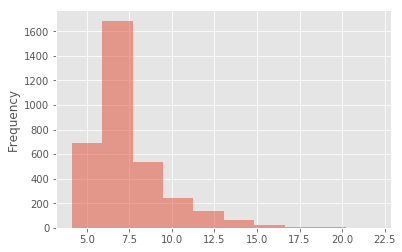

In [95]:
df_temp = join_total['hba1c_mean'];
df_temp.plot.hist(bins=10, alpha=0.5)

According to the histogram above, we think that making bin by equal size is not a good approach since the majority of patient will have the value between 6-7.5. Therefore, we will bin using quantile instead. We will try 1, 5, 10 ,20 quantile.

1 quantile


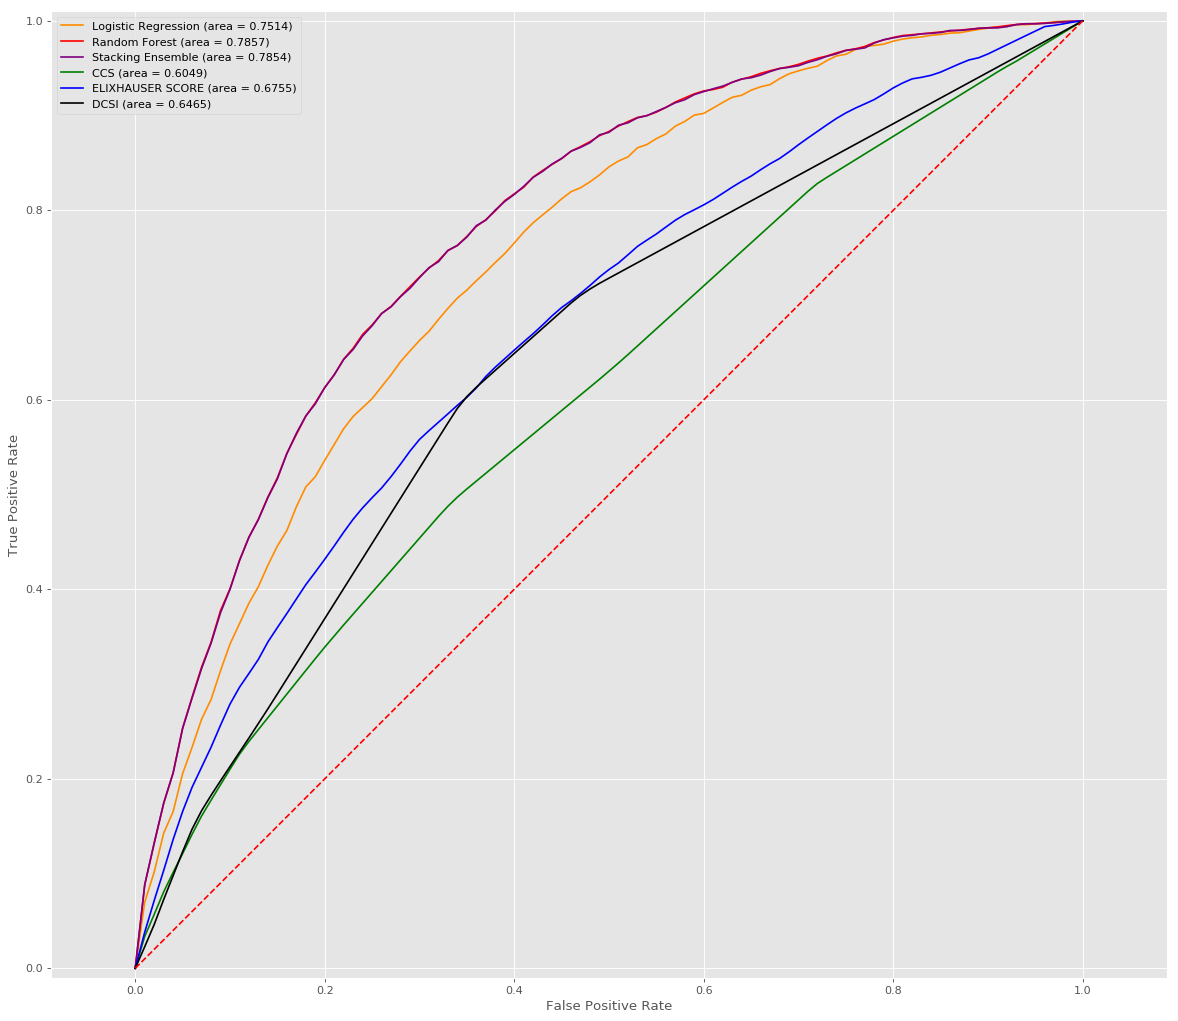

5 quantile


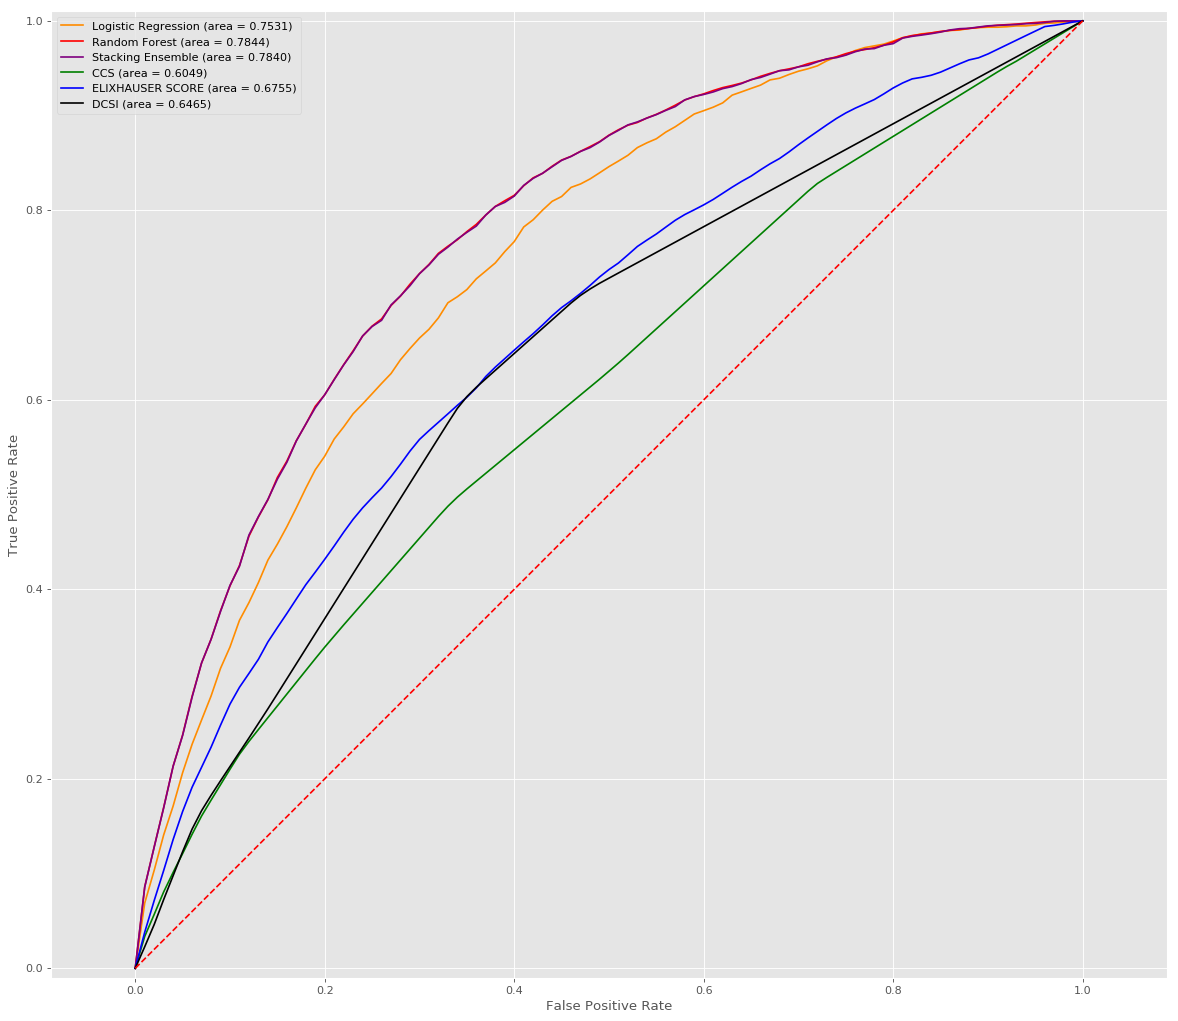

10 quantile


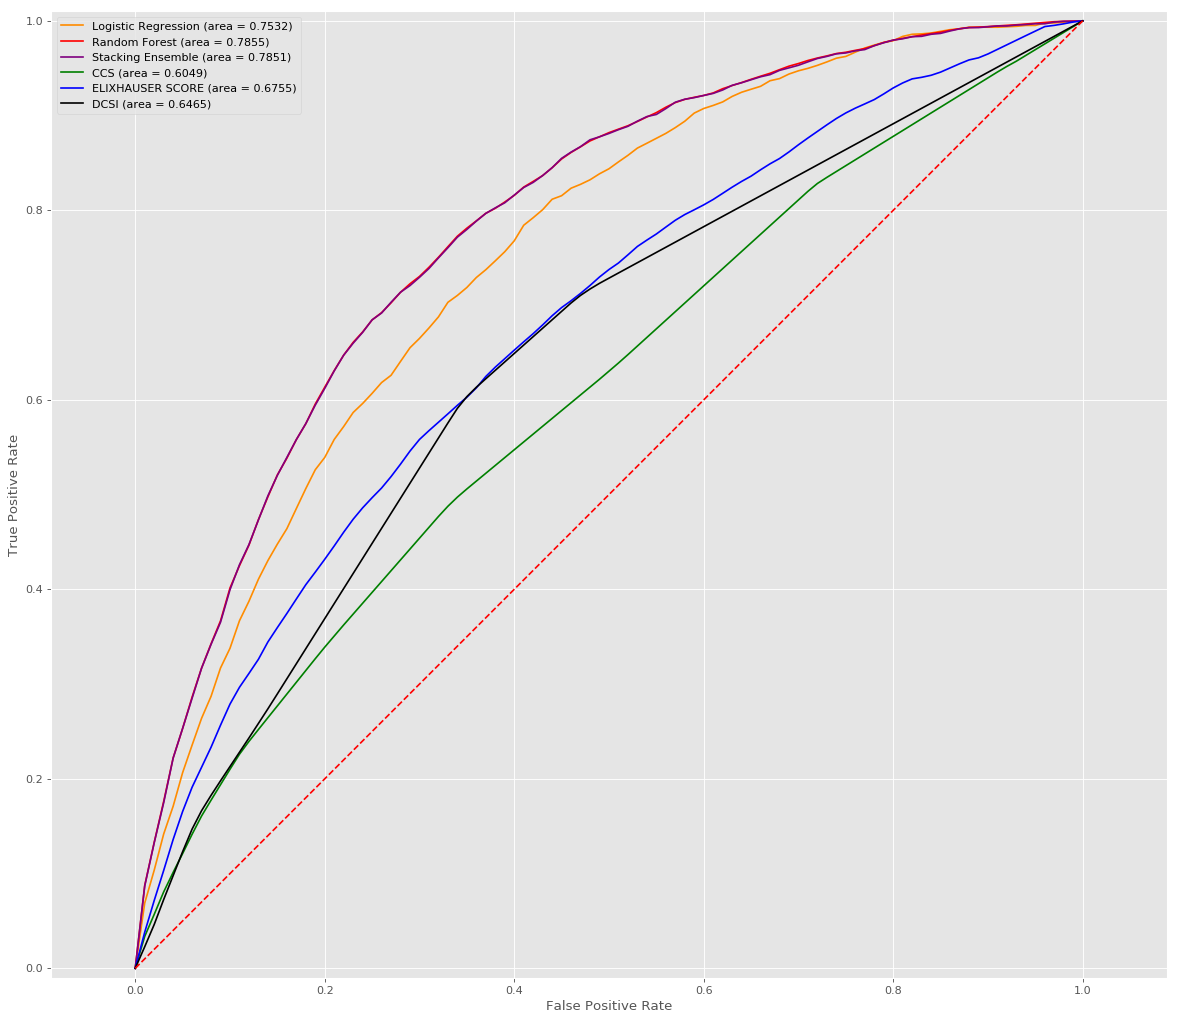

20 quantile


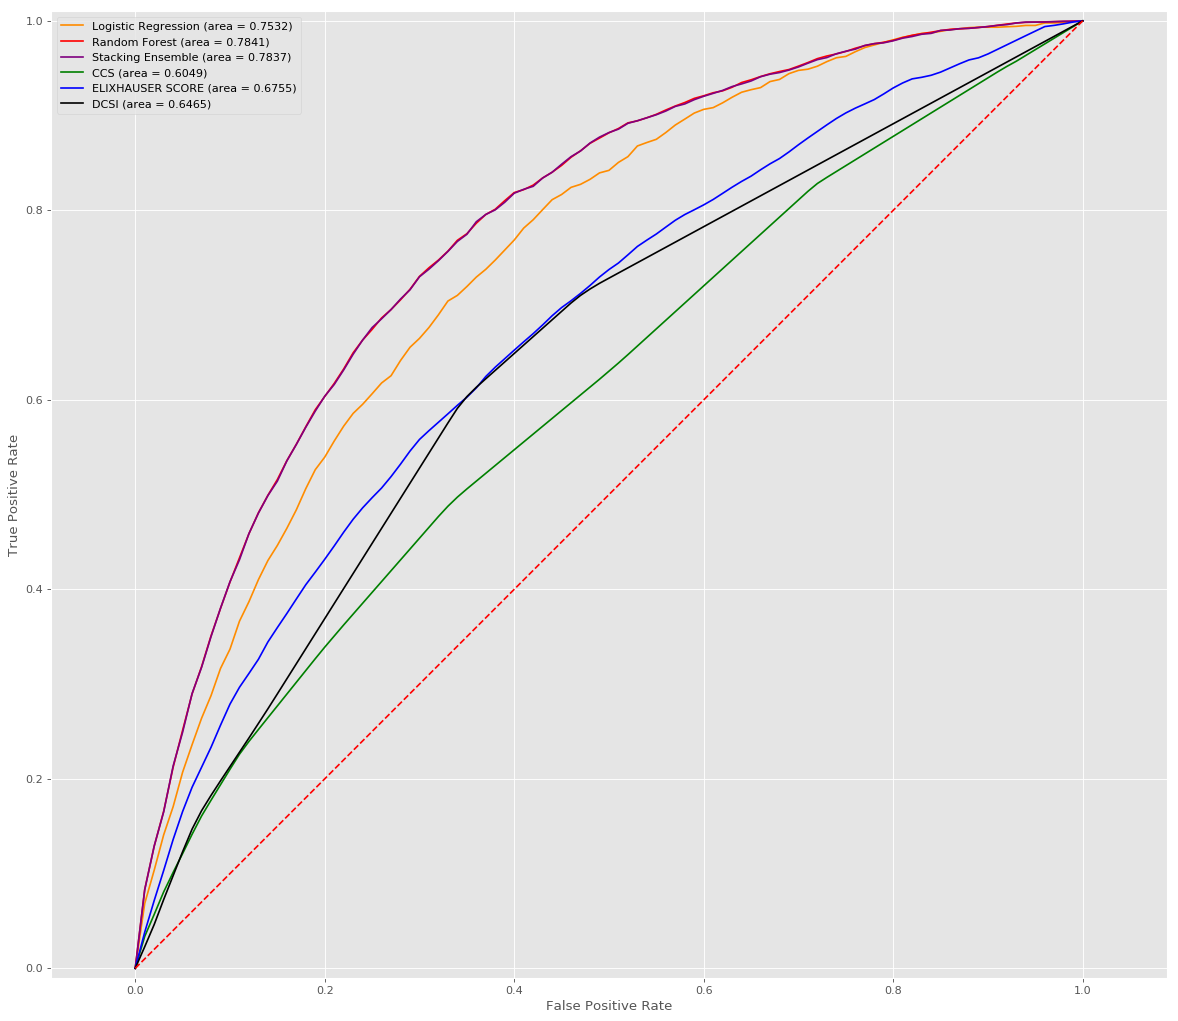

In [100]:


num_bins = [1,5,10,20];

for nb in num_bins:
    random.seed(2020)
    join_total_catHb =join_total.copy();
    join_total_catHb['hba1c_mean_cat'] = pd.qcut(join_total_catHb['hba1c_mean'], nb)
    join_total_catHb['hba1c_mean_cat'] = join_total_catHb['hba1c_mean_cat'].cat.codes
    join_total_catHb=join_total_catHb.drop('hba1c_mean', axis=1)



    X = join_total_catHb.dropna().drop('Death', axis=1).values;

    y = join_total_catHb.dropna()['Death'].values


    auc_logistic=[];
    auc_ccs=[];
    auc_eli=[];
    auc_dcsi=[];
    auc_RF=[];
    auc_stack=[];

    base_fpr = np.linspace(0, 1, 101)
    tprs_logistic = [];
    tprs_ccs = [];
    tprs_eli = [];
    tprs_dcsi = [];
    tprs_RF = [];
    tprs_stack = [];

    fpr_avg =[];
    tpr_avg =[];

    kf = KFold(n_splits=10)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]


        modelRF = RandomForestClassifier(n_estimators=500,bootstrap = True,
                                   max_features = 'sqrt',class_weight='balanced')
        model = LogisticReg(penalty='l2',solver='liblinear', class_weight = 'balanced')
        model.fit(X_train,y_train)
        modelRF.fit(X_train,y_train)

        y_train_predict = model.predict_proba(X_train)[:,1]
        y_train_predictRF = modelRF.predict_proba(X_train)[:,1]

        y_train_predict = y_train_predict[...,None]
        y_train_predictRF = y_train_predictRF[...,None]

        stack_predict_train = np.concatenate((y_train_predict, y_train_predictRF),axis=1)
        model_stack = LogisticRegression();

        model_stack.fit(stack_predict_train,y_train)


        #evaluate the model
        y_predict = model.predict_proba(X_test)[:,1]
        y_predictRF = modelRF.predict_proba(X_test)[:,1]

        y_predict = y_predict[...,None]
        y_predictRF = y_predictRF[...,None]

        stack_predict_test = np.concatenate((y_predict, y_predictRF),axis=1)

        y_stack_predict = model_stack.predict_proba(stack_predict_test)[:,1]


        fpr, tpr, _ = roc_curve(y_test, y_stack_predict)
        roc_auc = auc(fpr, tpr)
        auc_stack.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_stack.append(tpr)




        fpr, tpr, _ = roc_curve(y_test, y_predict)
        roc_auc = auc(fpr, tpr)
        auc_logistic.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_logistic.append(tpr)


        fpr, tpr, _ = roc_curve(y_test, y_predictRF)
        roc_auc = auc(fpr, tpr)
        auc_RF.append(roc_auc)


        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_RF.append(tpr)

        fpr, tpr, _ = roc_curve(y_test, X_test[:,0])
        roc_auc = auc(fpr, tpr)
        auc_ccs.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_ccs.append(tpr)


        fpr, tpr, _ = roc_curve(y_test, X_test[:,1])
        roc_auc = auc(fpr, tpr)
        auc_eli.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_eli.append(tpr)


        fpr, tpr, _ = roc_curve(y_test, X_test[:,2])
        roc_auc = auc(fpr, tpr)
        auc_dcsi.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs_dcsi.append(tpr)



    tprs_stack = np.array(tprs_stack)
    mean_tprs_stack = tprs_stack.mean(axis=0)
    roc_auc_stack = auc(base_fpr, mean_tprs_stack)       


    tprs_RF = np.array(tprs_RF)
    mean_tprs_RF = tprs_RF.mean(axis=0)
    roc_auc_RF = auc(base_fpr, mean_tprs_RF)    


    tprs_logistic = np.array(tprs_logistic)
    mean_tprs_logistic = tprs_logistic.mean(axis=0)
    roc_auc_logistic = auc(base_fpr, mean_tprs_logistic)

    tprs_ccs = np.array(tprs_ccs)
    mean_tprs_ccs = tprs_ccs.mean(axis=0)
    roc_auc_ccs  = auc(base_fpr, mean_tprs_ccs)

    tprs_eli = np.array(tprs_eli)
    mean_tprs_eli = tprs_eli.mean(axis=0)
    roc_auc_eli  = auc(base_fpr, mean_tprs_eli)

    tprs_dcsi = np.array(tprs_dcsi)
    mean_tprs_dcsi = tprs_dcsi.mean(axis=0)
    roc_auc_dcsi  = auc(base_fpr, mean_tprs_dcsi)


    #std = tprs.std(axis=0)

    #tprs_upper = np.minimum(mean_tprs + std, 1)
    #tprs_lower = mean_tprs - std

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    plt.plot(base_fpr, mean_tprs_logistic, 'darkorange', label='Logistic Regression (area = %0.4f)' % roc_auc_logistic)
    plt.plot(base_fpr, mean_tprs_RF, 'r', label='Random Forest (area = %0.4f)' % roc_auc_RF)
    plt.plot(base_fpr, mean_tprs_stack, 'purple', label='Stacking Ensemble (area = %0.4f)' % roc_auc_stack)

    plt.plot(base_fpr, mean_tprs_ccs, 'g', label='CCS (area = %0.4f)' % roc_auc_ccs)
    plt.plot(base_fpr, mean_tprs_eli, 'b', label='ELIXHAUSER SCORE (area = %0.4f)' % roc_auc_eli)
    plt.plot(base_fpr, mean_tprs_dcsi, 'k', label='DCSI (area = %0.4f)' % roc_auc_dcsi)
    #plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    print(str(nb)+' quantile')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend()
    plt.show()

# Coeffience and P value

In [101]:
p_values_round=["%.4f" % round(x, 4) for x in model.get_p_values()]
feature = list(join_total_catHb.columns)
feature.remove('Death')
df_show = pd.DataFrame({'Features':feature ,'Coefficient':list(model.get_coef()),'P values':p_values_round})
df_show

,Features,Coefficient,P values
0,CCS,0.013097,0.1310
1,elixhauser_sid30,0.042846,0.0000
2,DCSI,0.277604,0.0000
3,age,0.003880,0.0000
4,gender,-0.119400,0.0004
5,marital_status,-0.056325,0.0000
6,admission_type,0.520267,0.0000
7,ethnicity,0.017867,0.0000
8,insurance,-0.062287,0.0089
9,lab_glucose_mean,0.007994,0.0000


['CCS', 'elixhauser_sid30', 'DCSI', 'age', 'gender', 'marital_status', 'admission_type', 'ethnicity', 'insurance', 'lab_glucose_mean', 'serum_creatinine_mean', 'hba1c_mean_cat']


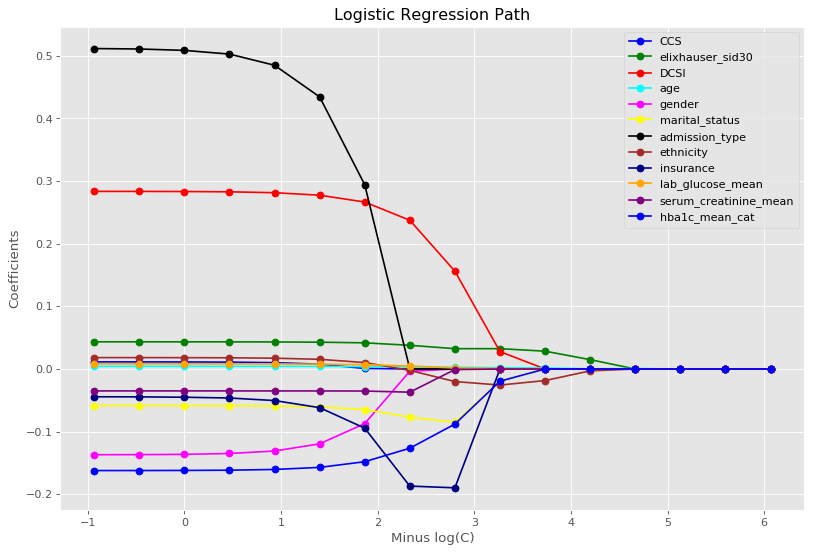

In [102]:

random.seed(2020)
join_total_catHb =join_total.copy();
join_total_catHb['hba1c_mean_cat'] = pd.qcut(join_total_catHb['hba1c_mean'], 10)
join_total_catHb['hba1c_mean_cat'] = join_total_catHb['hba1c_mean_cat'].cat.codes
join_total_catHb=join_total_catHb.drop('hba1c_mean', axis=1)

X = join_total_catHb.dropna().drop('Death', axis=1).values;
y = join_total_catHb.dropna()['Death'].values

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)
clf = LogisticRegression(penalty='l1',solver='liblinear', class_weight = 'balanced')
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_prop_cycle('color',['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'navy', 'orange', 'purple'])
feature = list(join_total_catHb.columns)
feature.remove('Death')
print(feature)
plt.plot(-np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('Minus log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.legend(feature)
plt.axis('tight')
plt.show()

The top three coefficients are admission_type, hba1c_mean_cat and DCSI. 

# Suggestions & Conclusion

### Evaluation 

All models are evaluated by area under a curve (auc) using 10-fold cross validation

For determining the top coefficients, we consider the magnitude first and then if the coefficients are close, we will consider how much it drop from the l1 penalty. All coefficients are considered only when p-value < 0.05. 

### Observations

During the experiment, we notice that

1) In the second approach, the number of quantile does not much effect the performance. This may be because the majority of patient don't have HbA1 (17479 vs 3393). The model may only learn to distinguish only from having HbA1c and not having HbA1c which is 1 quantile binning.

2) In all model created, DCSI is always in the top three important feature.

3) When the model handle NaN HbA1c data in both approachs, Random Forest work better than Logistic Regression. This may be because RF works better with categorical data. That is why ensemble method does not work well on the second approahc since RF is dominant.

4) gender is one of the top three features on HbA1c-available data while almost insignificant when in NaN HbA1c data. This may be the result of small dataset in the former (3393 patients) compared to the latter (17479 patients)

5) Categorical HbA1c (coefficient : -0.084) is not important to the model as much as HbA1c mean (coefficient : -0.333). This also may be because the majority of patient don't have HbA1 (17479 vs 3393).

6) Even though, ELIXHAUSER SCORE have highest AUC among the three comordity score (ELIXHAUSER SCORE, DCSI, CCS). The significant feature that all model choose is DCSI. This may be because DCSI is made specific for Diabetic patients (DCSI stands for Diabetes Complications Severity Index).

7) The stacking ensemble method is useful in the HbA1c dataset because both Logistic Regression and Random forest have similar performance in which each method have some part better than the other.

### Suggestions:

All of the aforementioned observations should be further investigated for their correctness.

The following are suggestions and the number are associated with the observation above.

1) We only have 3 type of model Logistic Regression, Random forest and the ensemble method. To conclude that the number of quantile are irrelevant, more model should be tested such as svm or GAM and best subset selection also can be help clarify this claim

3) There are many hyperparameter associated with Random forest (number of decision trees)and Logistic regression (L1, L2 penalty). Extensive search for the best hyperparameters of both model using methods such as cross validation can confirm the claim.

5) We only test the model using catergorical HbA1c tranformed by splitting quantile. Other splitting methods such as grouping by similarity like k-mean or using equal range shoule be tested to confirm the claim.

6) Additional models should be tested to confirm the claim in general.

### Conclusion:

Answering the questions

1) find out how standard comordity scores perform on ICU diabetic patients and whether we can improve the model by using the combined method or by providing additional information (HbA1c, glucise and serum creatinine)

Answer 

Our new models work better than original cormordity score in all cases. The reason may be because the additional data added to the network is significant for prediction.

2) find out how the model performs on different dataset 1) patients with HbA1c data and 2) patients with out the data.

Answer 

In the first case, Logistic Regression (LR) (auc : 0.7646) and Random Forest (RF) (auc : 0.7732) have relatively the same performance. while in the second case, RF (auc : 0.7779) performs better than LR (auc : 0.7432). This may be because the significant features are shifted to more categotical data in which RF work better (Top three features : dataset 1 : DCSI (continue), HbA1c (continue), gender (category), dataset 2: DCSI (continue), admission type (category), insurance (category)). 



3) find out which is the best way to create a model that can handle both cases of patients. Two approaches are tested in this project. 1) Building separate model on each dataset 2) changing HbA1c to catergorical data and add NaN as another category.

Answer

Using categoric approach (best model : RF, auc : 0.7857) compared to split the models (best model : stacking ensemble model, auc : 0.7808) performs slightly better. Moreover, given the same performance, this approach still benefit from having only one model reducing the calculated time.

4) In Logistic Regression model, we want to find out which factor contributes to the result most.

Answer 

In dataset with patients with HbA1c data, the top three features are DCSI, HbA1c and gender. In dataset with patients without HbA1c, the top three features are DCSI, admission type and insurance. In the whole dataset, the top three features are DCSI, admission type and categorical HbA1c.